<img src="Ames.jpg" width="700">

# <u>Ames Housing Regression Project<u> 

## `1` Introduction

### `1.1` Regression and Classification with the Ames Housing Data

You have just joined a new *full stack* property company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimise investment and maximise return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

### `1.2` Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model as linear_model
import statsmodels.api as sm

from sklearn import datasets, metrics, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LassoCV, Lasso, LinearRegression, RidgeCV, Ridge, ElasticNetCV, ElasticNet, BayesianRidge, OrthogonalMatchingPursuit, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.dummy import DummyRegressor

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## `2` Estimating the value of homes from fixed characteristics

### `2.1` Problem

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that can be renovated:
- Roof and exterior features
- Quality metrics, such as kitchen quality
- Condition metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
2. Be sure to remove any houses that are not residential from the dataset.
3. Identify **fixed** features that can predict price.
4. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
5. Characterise your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

---

### `2.2` Solution

#### `2.2.1` Exploratory data analysis (EDA)

**<u>A. Preliminaries<u>**

In [2]:
Ames = pd.read_csv('Housing.csv')
Ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
Ames.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
Ames['Id'].nunique()

1460

Since the number of unique Id entries is equal to the number of rows we can assume there are no duplicates.

In [5]:
Ames.columns = map(str.lower, Ames.columns)
Ames.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

**<u>B. Removing non-residential and non-normal<u>**

In [6]:
Ames.mszoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64

Residential properties must contain the letter 'r' in the mszoning feature so we refine our dataset accordingly:

In [7]:
Ames = Ames[Ames['mszoning'].str.contains('R')]
Ames.mszoning.value_counts()

RL    1151
RM     218
RH      16
Name: mszoning, dtype: int64

---

In [8]:
Ames2 = Ames.copy()

---

In [9]:
Ames.salecondition.value_counts()

Normal     1155
Partial     103
Abnorml      92
Family       20
Alloca       11
AdjLand       4
Name: salecondition, dtype: int64

In [10]:
Ames = Ames[Ames['salecondition'] == 'Normal']
Ames.salecondition.value_counts()

Normal    1155
Name: salecondition, dtype: int64

**<u>C. Splitting the data into fixed and unfixed<u>**

---

We will create two separate lists, one of fixed characteristics and another of unfixed charactersitics. In this situation our fixed are the features that cannot be renovated and the unfixed are the ones that can be renovated.

In [11]:
fixed = [
    'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
    'lotshape', 'landcontour', 'lotconfig', 'landslope', 'neighborhood',
    'condition1', 'condition2', 'bldgtype', 'housestyle', 'yearbuilt',
    'yearremodadd', 'foundation', 'bsmtqual', 'bsmtfinsf1', 'bsmtfinsf2',
    'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf',
    'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
    'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagetype',
    'garageyrblt', 'garagecars', 'garagearea', 'yrsold', 'salecondition', 'saleprice'
]

We have included 'yrsold', 'salecondition' and 'saleprice' as these will be needed later in the project to make predictions.

In [12]:
Ames_fixed = Ames[fixed].copy()

In [13]:
unfixed = [
    '3ssnporch', 'salecondition', 'miscfeature', 'screenporch', 'functional',
    'garagecond', 'poolqc', 'fence', 'heating', 'masvnrtype', 'bsmtexposure',
    'utilities', 'fireplacequ', 'bsmtfintype1', 'exterqual', 'exterior1st',
    'exterior2nd', 'roofstyle', 'kitchenqual', 'miscval', 'masvnrarea',
    'enclosedporch', 'centralair', 'garagequal', 'bsmtfintype2', 'openporchsf',
    'heatingqc', 'wooddecksf', 'paveddrive', 'overallcond', 'poolarea',
    'bsmtcond', 'garagefinish', 'electrical', 'roofmatl', 'extercond',
    'overallqual', 'yrsold'
]

**<u>D. Dealing with NaN values<u>**

In [14]:
missing_count = pd.DataFrame(Ames_fixed.isna().sum().sort_values(ascending=False), columns=['fixed'])
missing_chars = missing_count[missing_count['fixed'] >= 1]
missing_chars

fixed
alley         1099
lotfrontage    230
garageyrblt     61
garagetype      61
bsmtqual        32

In [15]:
Ames_fixed[missing_chars.index].head(10)

alley  lotfrontage  garageyrblt garagetype bsmtqual
0    NaN         65.0       2003.0     Attchd       Gd
1    NaN         80.0       1976.0     Attchd       Gd
2    NaN         68.0       2001.0     Attchd       Gd
4    NaN         84.0       2000.0     Attchd       Gd
5    NaN         85.0       1993.0     Attchd       Gd
6    NaN         75.0       2004.0     Attchd       Ex
7    NaN          NaN       1973.0     Attchd       Gd
9    NaN         50.0       1939.0     Attchd       TA
10   NaN         70.0       1965.0     Detchd       TA
12   NaN          NaN       1962.0     Detchd       TA

In [16]:
# Alley:
print(Ames_fixed.alley.unique())

# Data_description indicates nan is no alley access (NA).
# Replace nan with NA. 
Ames_fixed.alley.fillna('NA', inplace = True)
print(Ames_fixed.alley.unique())

[nan 'Grvl' 'Pave']
['NA' 'Grvl' 'Pave']


In [17]:
# Lotfrontage:
print(Ames_fixed.lotfrontage.isnull().value_counts())

# Data_description indicates nan is no street (in feet) connected to the property.
# Replace nan with 0.
Ames_fixed.lotfrontage.fillna(0, inplace = True)
print(Ames_fixed.lotfrontage.isnull().value_counts())

False    925
True     230
Name: lotfrontage, dtype: int64
False    1155
Name: lotfrontage, dtype: int64


In [18]:
# Garageyrblt:
print(Ames_fixed.garageyrblt.isnull().value_counts())

# Data_description indicates nan is no garage at property.
# Replace nan with 0.
Ames_fixed.garageyrblt.fillna(0, inplace = True)
print(Ames_fixed.garageyrblt.isnull().value_counts())

False    1094
True       61
Name: garageyrblt, dtype: int64
False    1155
Name: garageyrblt, dtype: int64


In [19]:
# Garagetype:
print(Ames_fixed.garagetype.isnull().value_counts())

# Data_description indicates nan is no garage at property.
# Replace nan with 0.
Ames_fixed.garagetype.fillna(0, inplace = True)
print(Ames_fixed.garagetype.isnull().value_counts())

False    1094
True       61
Name: garagetype, dtype: int64
False    1155
Name: garagetype, dtype: int64


In [20]:
# Bsmtqual:
print(Ames_fixed.bsmtqual.isnull().value_counts())

# Data_description indicates nan is no basement at property.
# Replace nan with 0.
Ames_fixed.bsmtqual.fillna(0, inplace = True)
print(Ames_fixed.bsmtqual.isnull().value_counts())

False    1123
True       32
Name: bsmtqual, dtype: int64
False    1155
Name: bsmtqual, dtype: int64


---

All nan values have been succesfully corrected!

---

**<u>E. Splitting the data into numerical & categorical<u>**

In [21]:
# Breaking the dataframe into categorical data we see there are 16 columns.
fixed_cat = Ames_fixed.select_dtypes(include=['object'])
print(fixed_cat.shape)
fixed_cat.head()

(1155, 16)


mszoning street alley lotshape landcontour lotconfig landslope neighborhood  \
0       RL   Pave    NA      Reg         Lvl    Inside       Gtl      CollgCr   
1       RL   Pave    NA      Reg         Lvl       FR2       Gtl      Veenker   
2       RL   Pave    NA      IR1         Lvl    Inside       Gtl      CollgCr   
4       RL   Pave    NA      IR1         Lvl       FR2       Gtl      NoRidge   
5       RL   Pave    NA      IR1         Lvl    Inside       Gtl      Mitchel   

  condition1 condition2 bldgtype housestyle foundation bsmtqual garagetype  \
0       Norm       Norm     1Fam     2Story      PConc       Gd     Attchd   
1      Feedr       Norm     1Fam     1Story     CBlock       Gd     Attchd   
2       Norm       Norm     1Fam     2Story      PConc       Gd     Attchd   
4       Norm       Norm     1Fam     2Story      PConc       Gd     Attchd   
5       Norm       Norm     1Fam     1.5Fin       Wood       Gd     Attchd   

  salecondition  
0        Normal  
1        Normal  
2        Normal  
4        Normal  
5        Normal

In [22]:
# Breaking the dataframe into numerical data we see there are 26 columns.
fixed_num = Ames_fixed.select_dtypes(include=['int64','float64'])
fixed_num.head()

mssubclass  lotfrontage  lotarea  yearbuilt  yearremodadd  bsmtfinsf1  \
0          60         65.0     8450       2003          2003         706   
1          20         80.0     9600       1976          1976         978   
2          60         68.0    11250       2001          2002         486   
4          60         84.0    14260       2000          2000         655   
5          50         85.0    14115       1993          1995         732   

   bsmtfinsf2  bsmtunfsf  totalbsmtsf  1stflrsf  ...  halfbath  bedroomabvgr  \
0           0        150          856       856  ...         1             3   
1           0        284         1262      1262  ...         0             3   
2           0        434          920       920  ...         1             3   
4           0        490         1145      1145  ...         1             4   
5           0         64          796       796  ...         1             1   

   kitchenabvgr  totrmsabvgrd  fireplaces  garageyrblt  garagecars  \
0             1             8           0       2003.0           2   
1             1             6           1       1976.0           2   
2             1             6           1       2001.0           2   
4             1             9           1       2000.0           3   
5             1             5           0       1993.0           2   

   garagearea  yrsold  saleprice  
0         548    2008     208500  
1         460    2007     181500  
2         608    2008     223500  
4         836    2008     250000  
5         480    2009     143000  

[5 rows x 26 columns]

---

**<u>F. Visualisations<u>**

In [23]:
Ames_fixed.columns

Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'yearbuilt',
       'yearremodadd', 'foundation', 'bsmtqual', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garagetype', 'garageyrblt', 'garagecars', 'garagearea', 'yrsold',
       'salecondition', 'saleprice'],
      dtype='object')

*Overview of distributions for numerical variables using histograms:*

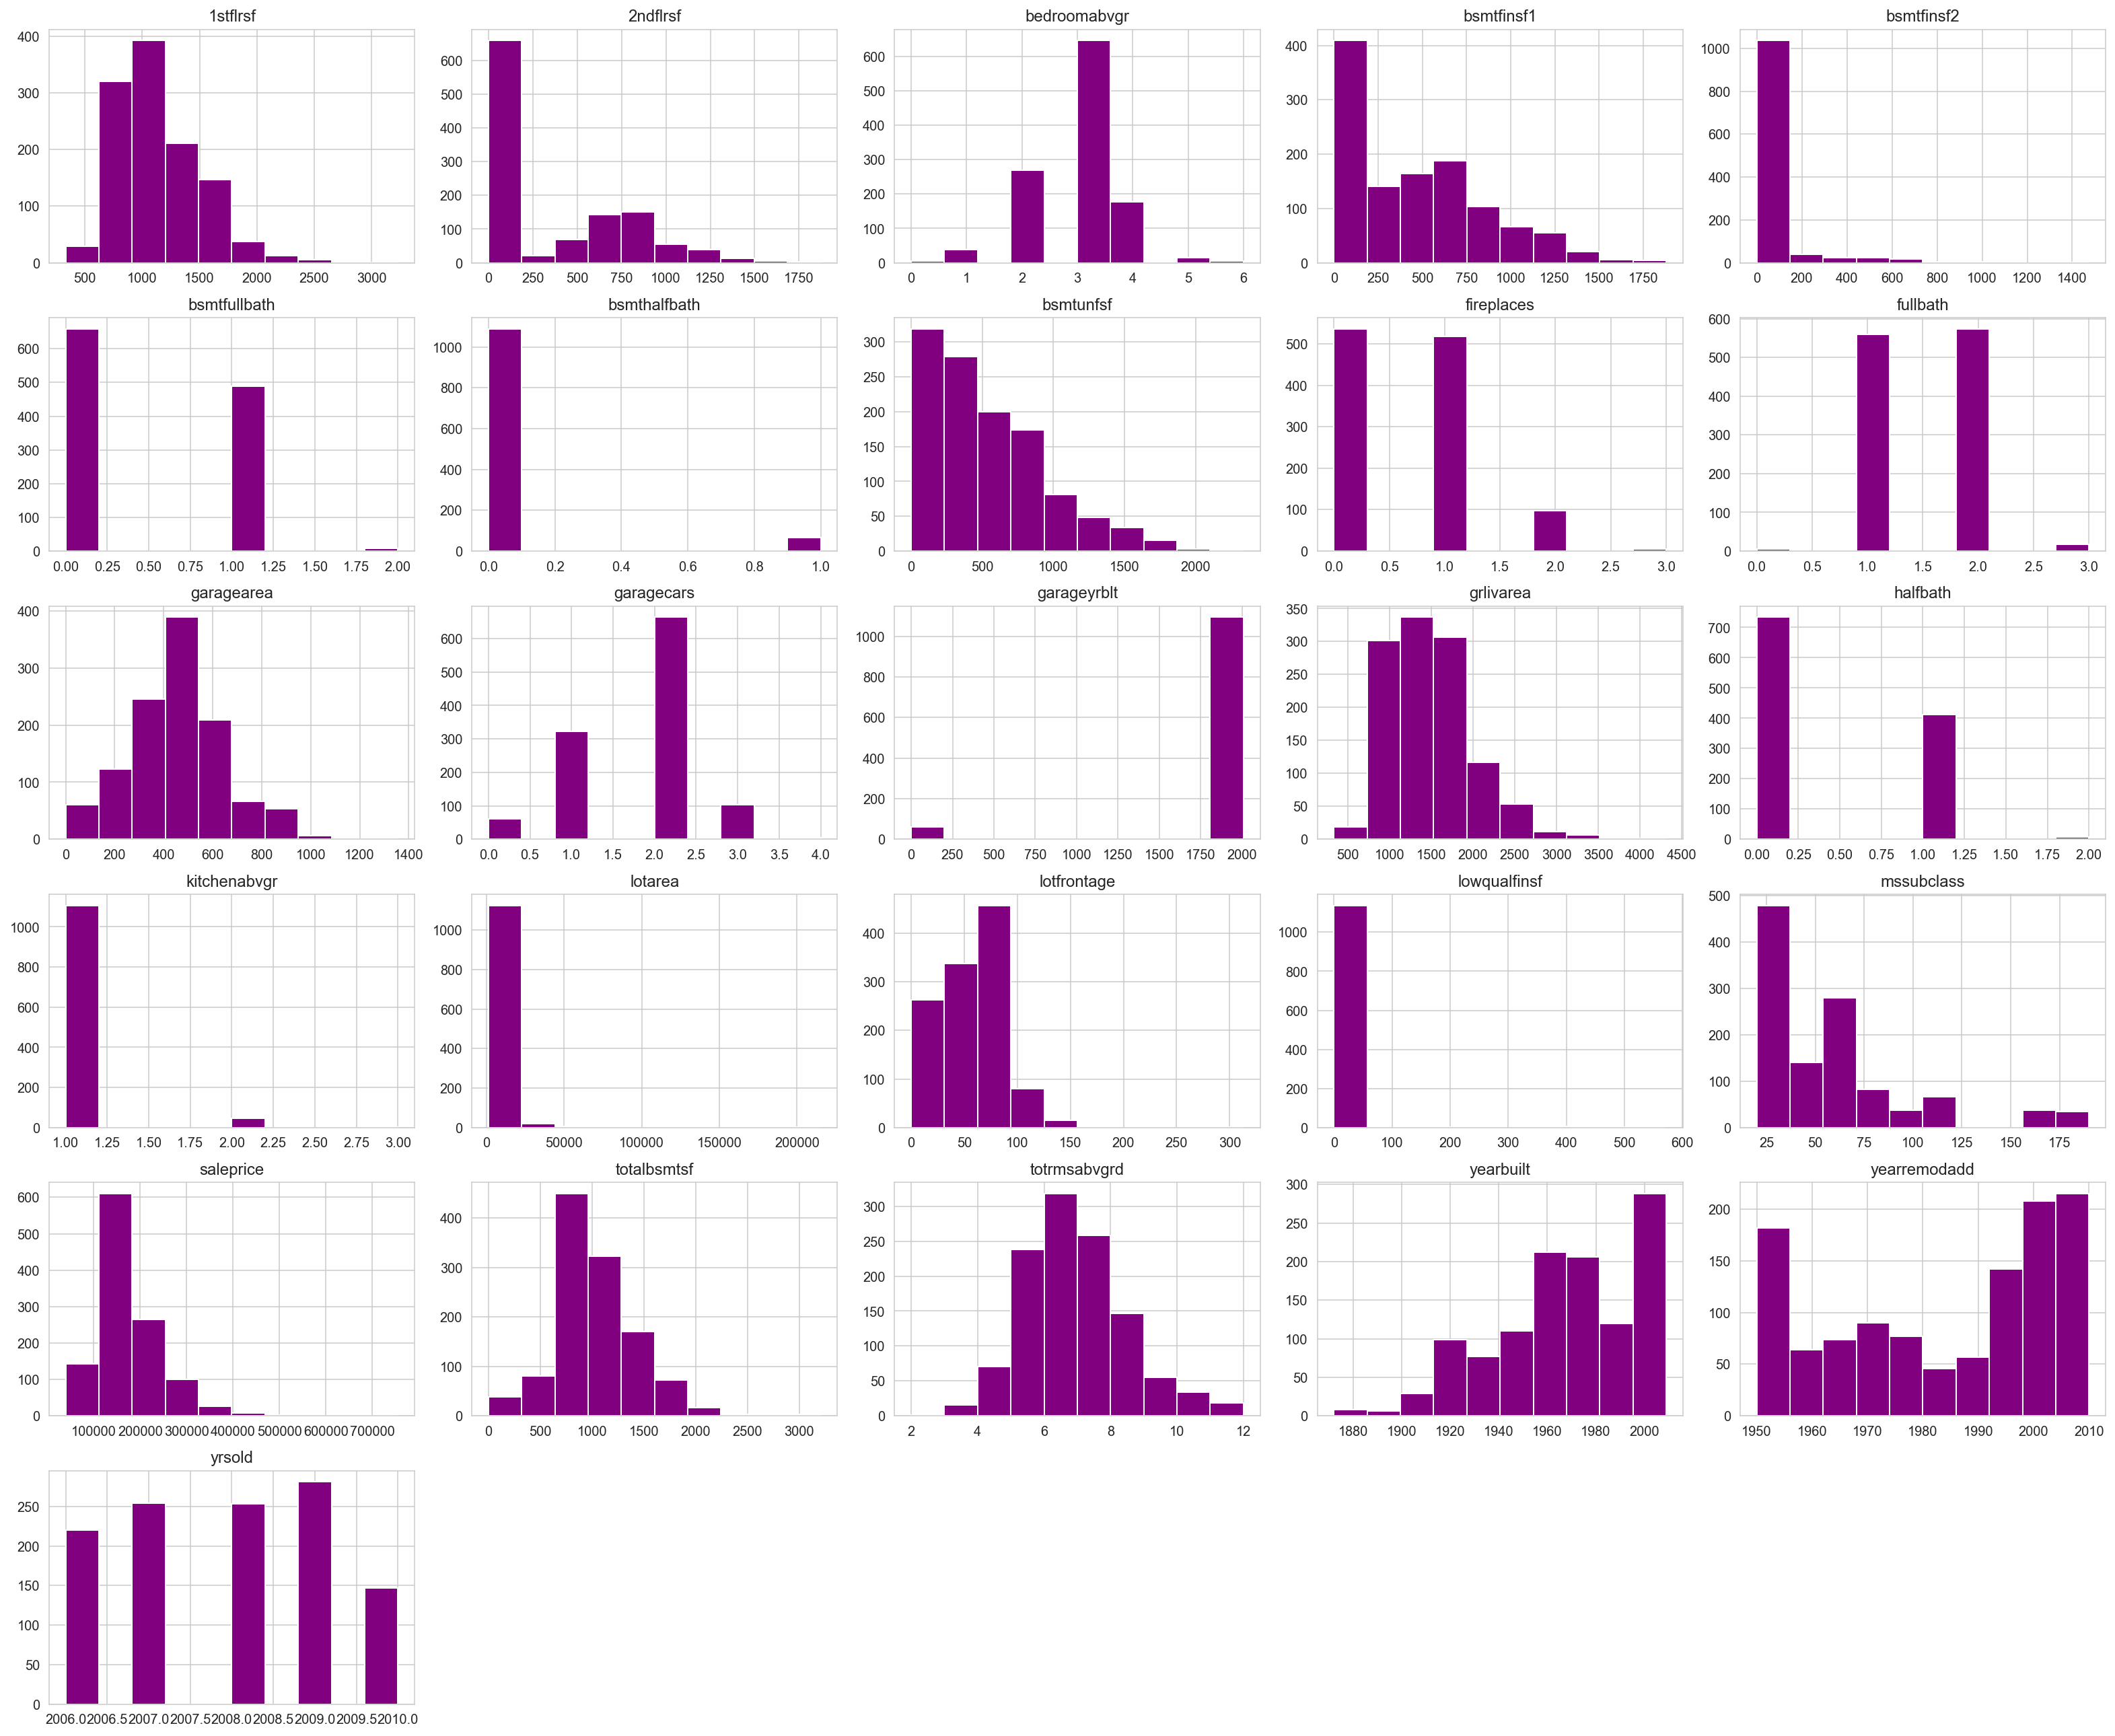

In [24]:
ax = fixed_num.hist(figsize=(22,18), color = 'purple')
plt.tight_layout()
plt.show()

*Overview of distributions for categorical variables using histograms:*

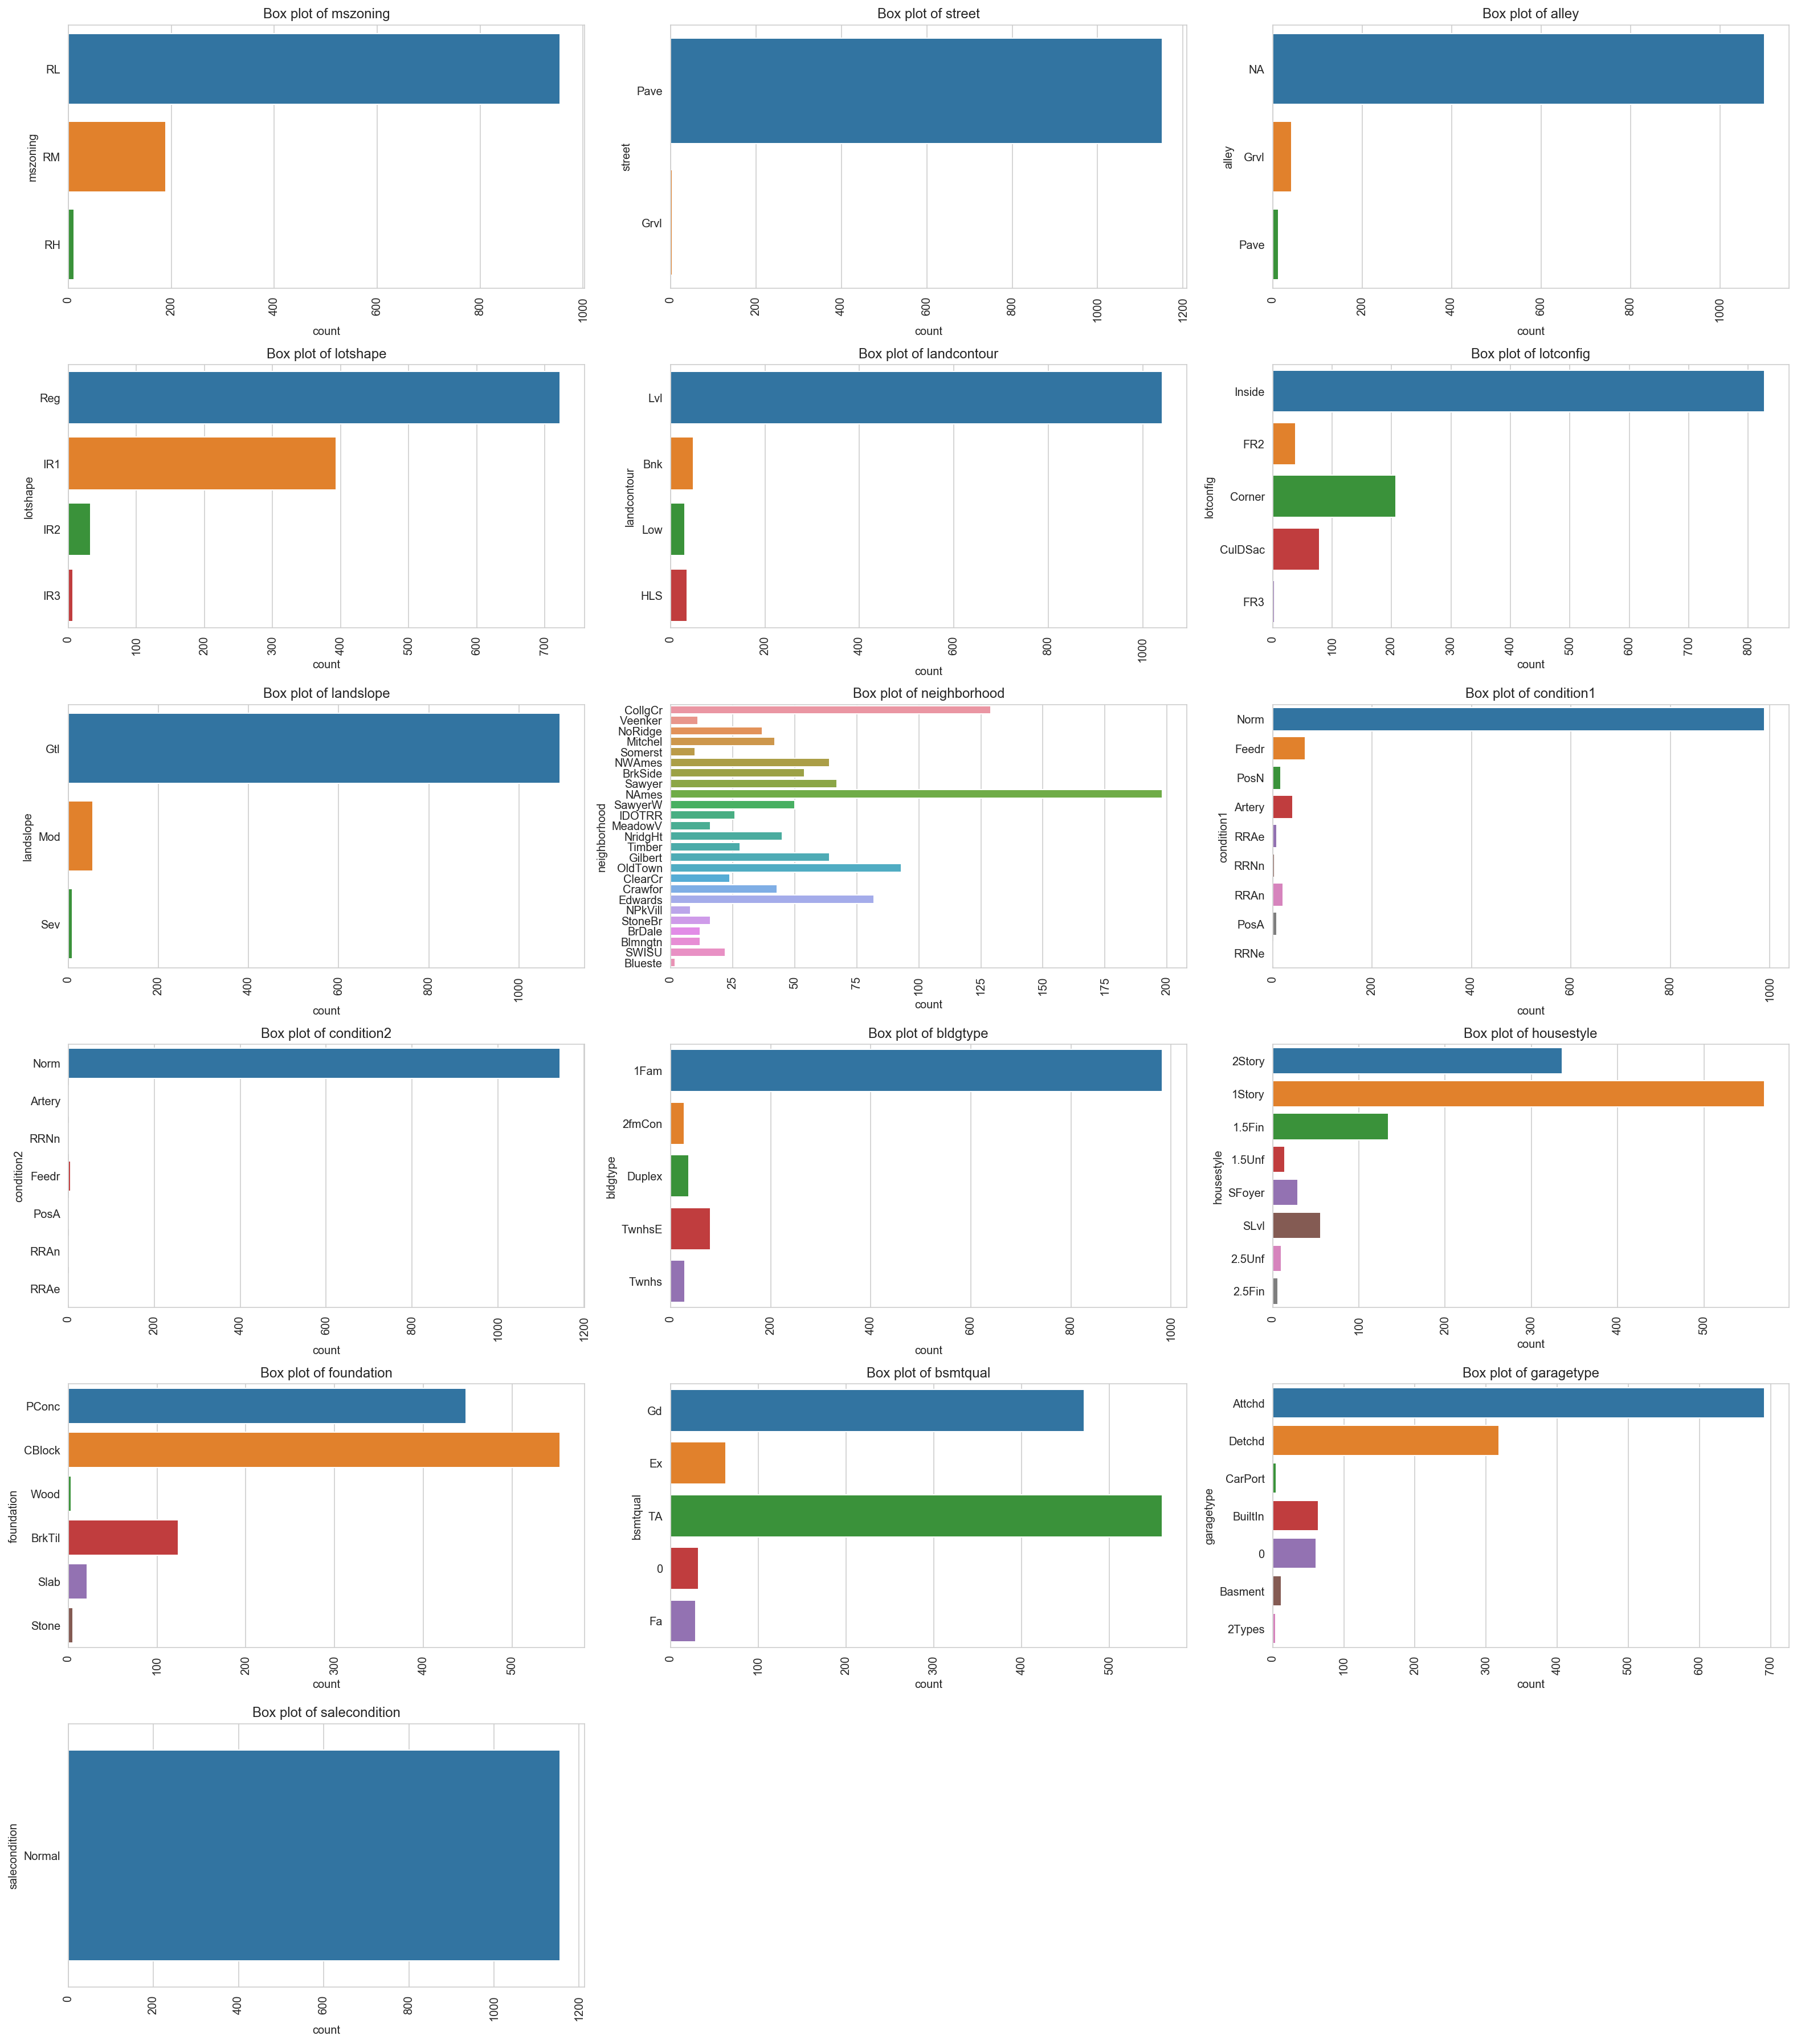

In [25]:
# Box plots for the categorical features:
var = fixed_cat.columns

fig = plt.figure(figsize=(22,25), facecolor='white')
for i, v in enumerate(var):
    plt.subplot(6,3,i+1)
    sns.countplot(y=v, data=fixed_cat)
    plt.title('Box plot of {}'.format(v))   
    plt.xticks(rotation='vertical')
plt.tight_layout()

**<u>G. Outliers<u>**

Clearly we will only be able to correct for outliers in numerical features. The standard IQR method will be used:

In [26]:
# Numerical 
Q1 = fixed_num.quantile(0.25)
Q3 = fixed_num.quantile(0.75)
IQR = Q3 - Q1

((fixed_num < (Q1 - 1.5 * IQR)) |(fixed_num > (Q3 + 1.5 * IQR))).sum()

mssubclass       71
lotfrontage      11
lotarea          69
yearbuilt         6
yearremodadd      0
bsmtfinsf1        3
bsmtfinsf2      148
bsmtunfsf        20
totalbsmtsf      56
1stflrsf         20
2ndflrsf          2
lowqualfinsf     19
grlivarea        19
bsmtfullbath      0
bsmthalfbath     66
fullbath          0
halfbath          0
bedroomabvgr     25
kitchenabvgr     48
totrmsabvgrd     18
fireplaces        4
garageyrblt      61
garagecars        4
garagearea        5
yrsold            0
saleprice        55
dtype: int64

Since we have relatively few outliers we shall leave them in since they carry little statistical impact.

#### `2.2.2` Identifying fixed features that can predict price

**<u>A. Categorical features<u>**

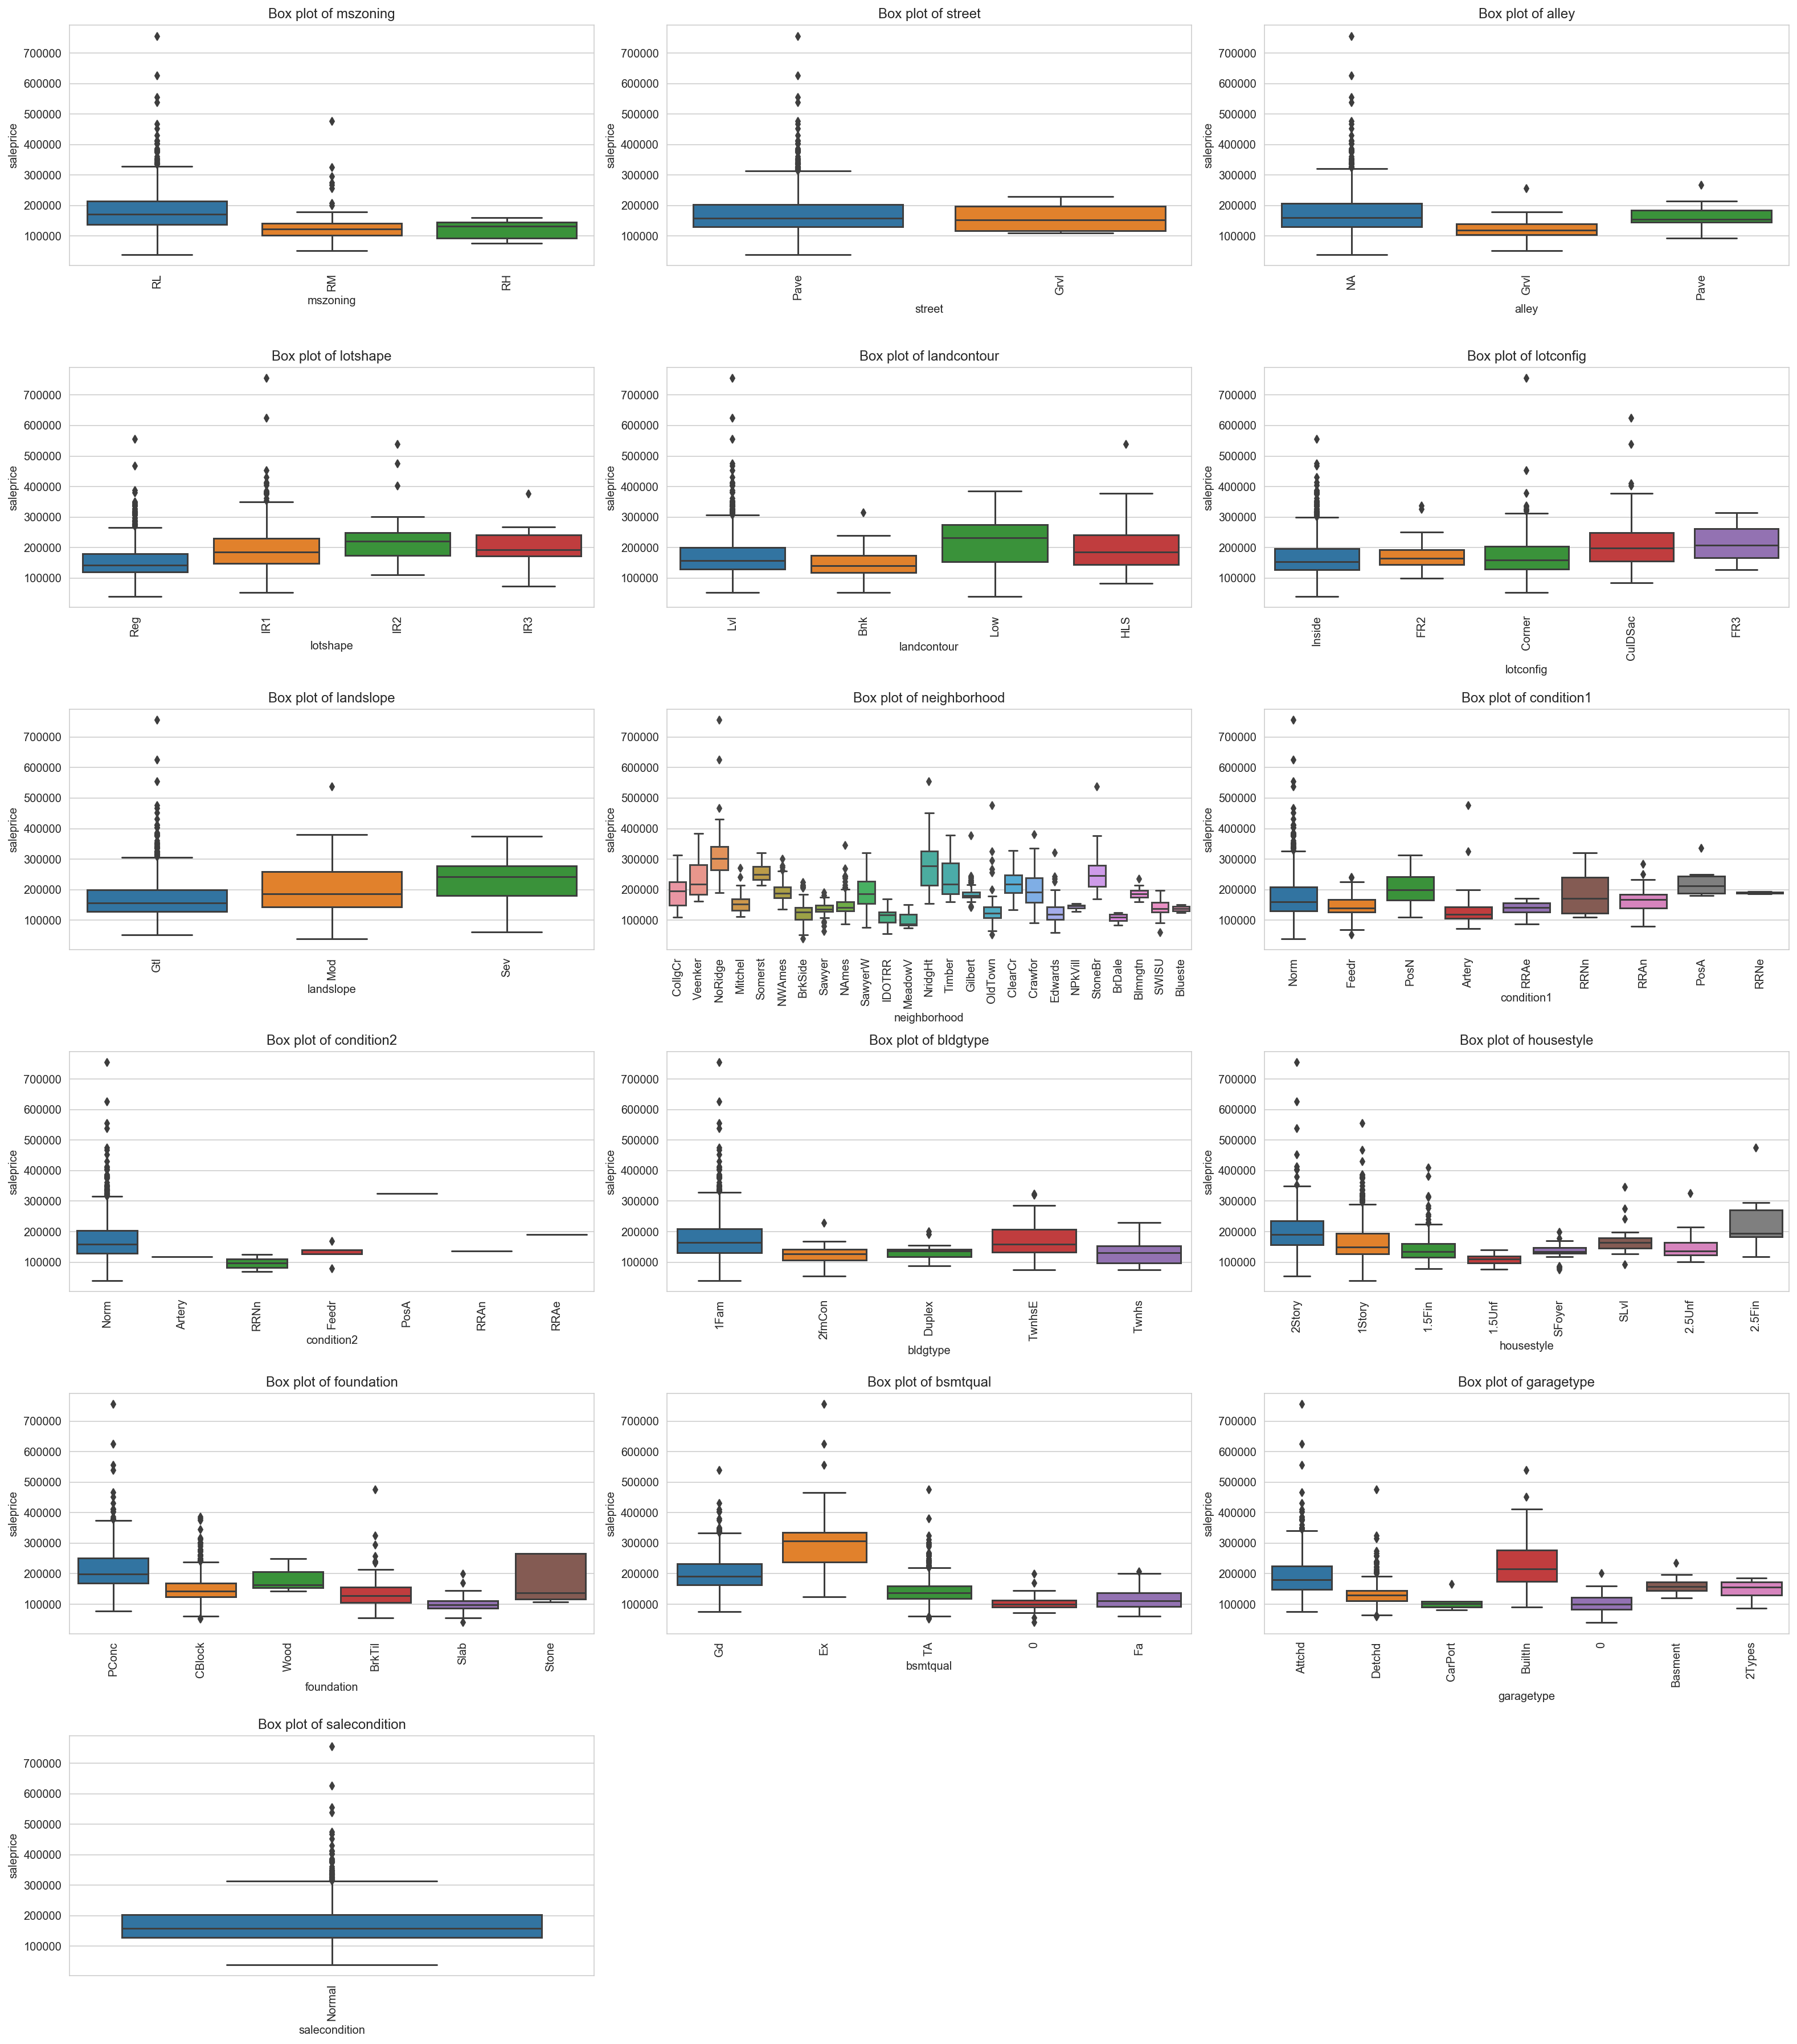

In [27]:
# Box plots for the categorical features:
var = fixed_cat.columns

fig = plt.figure(figsize=(22,25), facecolor='white')
for i, v in enumerate(var):
    plt.subplot(6,3,i+1)
    sns.boxplot(x=v, y='saleprice', data=Ames_fixed)
    plt.title('Box plot of {}'.format(v))   
    plt.xticks(rotation='vertical')
plt.tight_layout()

**<u>B. Numerical features<u>**

Changing mssubclass:

In [28]:
# Get data type of column 'mssubclass'
print(Ames_fixed.mssubclass.dtypes)

# We can see the mssubclass feature was loaded as in integer. However we want to convert it to a categorical variable.
Ames_fixed.mssubclass = Ames_fixed.mssubclass.astype(str)
print(Ames_fixed.mssubclass.dtypes)

int64
object


In [29]:
# List correlations between numerical features and saleprice:
corr_mat = Ames_fixed.corr()
corr_mat_abs = abs(corr_mat['saleprice'])
corr_mat['saleprice'].sort_values(ascending=False)

saleprice       1.000000
grlivarea       0.744814
totalbsmtsf     0.635159
garagecars      0.628238
1stflrsf        0.624713
garagearea      0.613053
fullbath        0.559432
totrmsabvgrd    0.528018
yearbuilt       0.489296
fireplaces      0.483572
yearremodadd    0.470365
bsmtfinsf1      0.416993
2ndflrsf        0.354004
lotarea         0.299911
halfbath        0.299249
garageyrblt     0.266685
bsmtfullbath    0.242354
bedroomabvgr    0.217075
bsmtunfsf       0.197791
lotfrontage     0.148170
bsmtfinsf2      0.021107
bsmthalfbath    0.004680
yrsold          0.000183
lowqualfinsf   -0.012233
kitchenabvgr   -0.143745
Name: saleprice, dtype: float64

In [30]:
# Print numerical variables with correlation coefficient of at least 0.5 to SalePrice
corr_mat['saleprice'].get([i for i, v in enumerate(corr_mat_abs) if v > 0.5]).sort_values(ascending=False)

saleprice       1.000000
grlivarea       0.744814
totalbsmtsf     0.635159
garagecars      0.628238
1stflrsf        0.624713
garagearea      0.613053
fullbath        0.559432
totrmsabvgrd    0.528018
Name: saleprice, dtype: float64

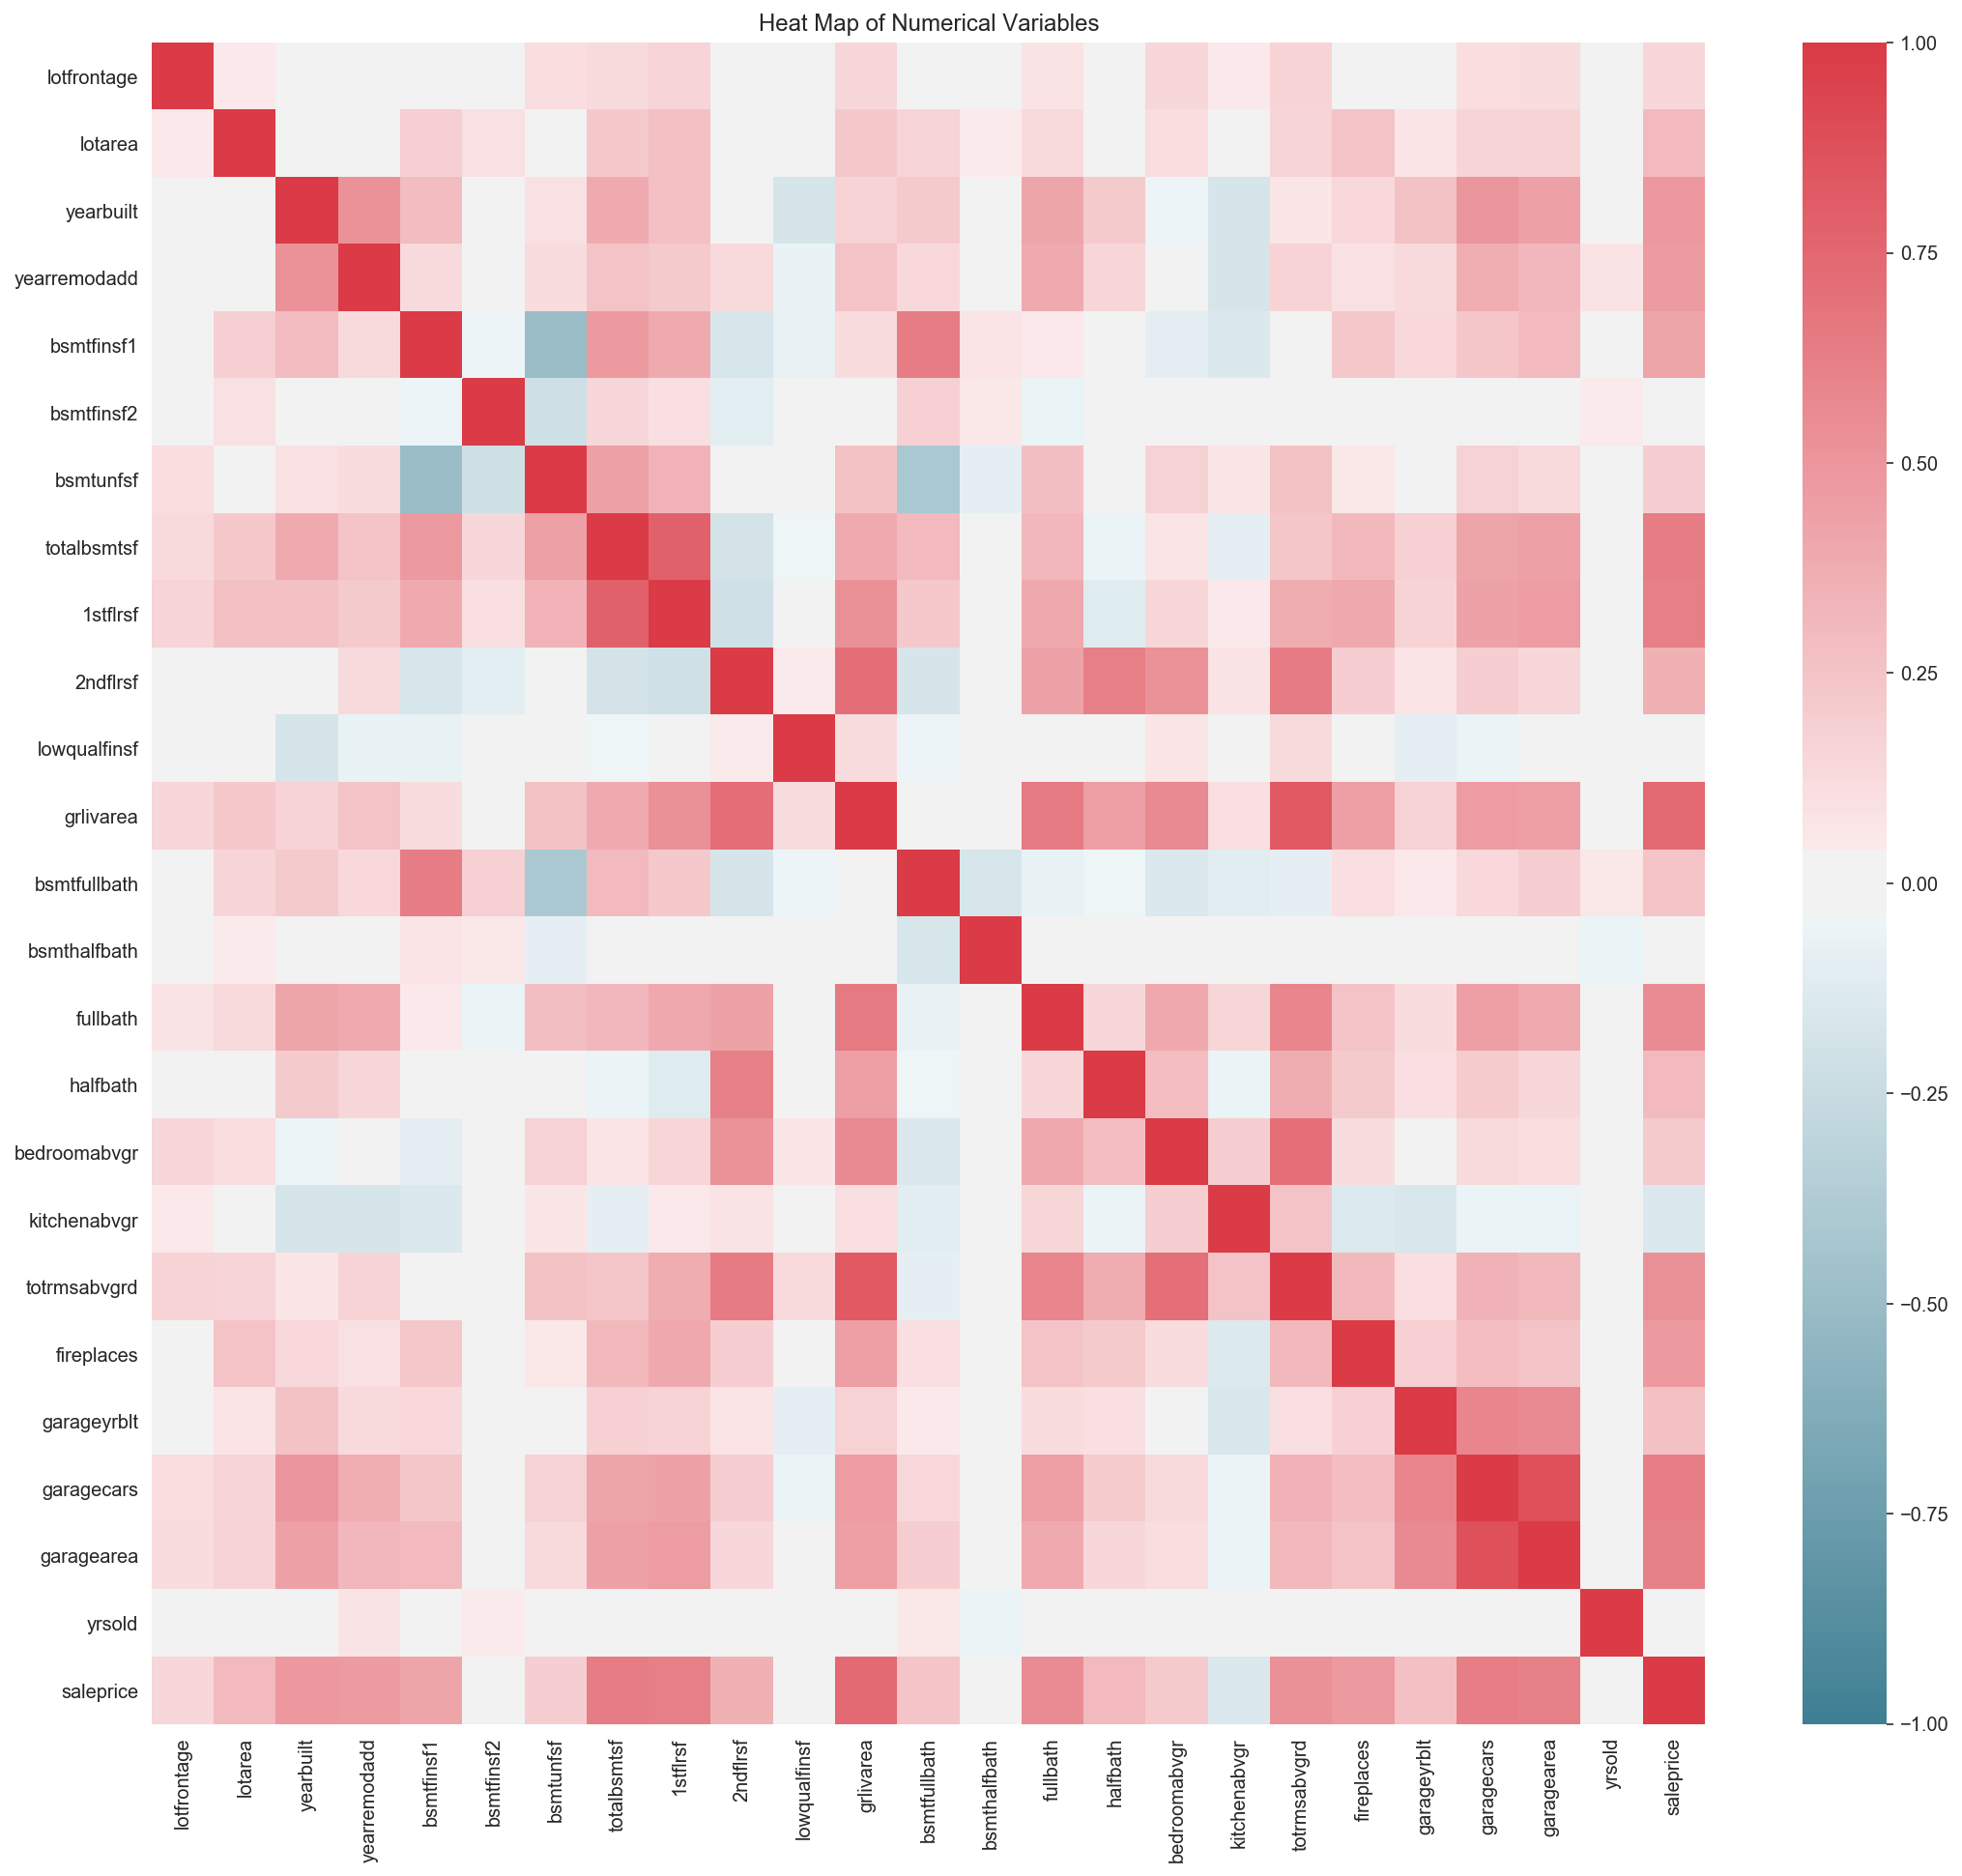

In [31]:
# Heat map to look at correlations:
plt.figure(figsize=(18,16), facecolor='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(Ames_fixed.corr(), cmap=cmap, vmin=-1)
plt.title('Heat Map of Numerical Variables')
plt.show()

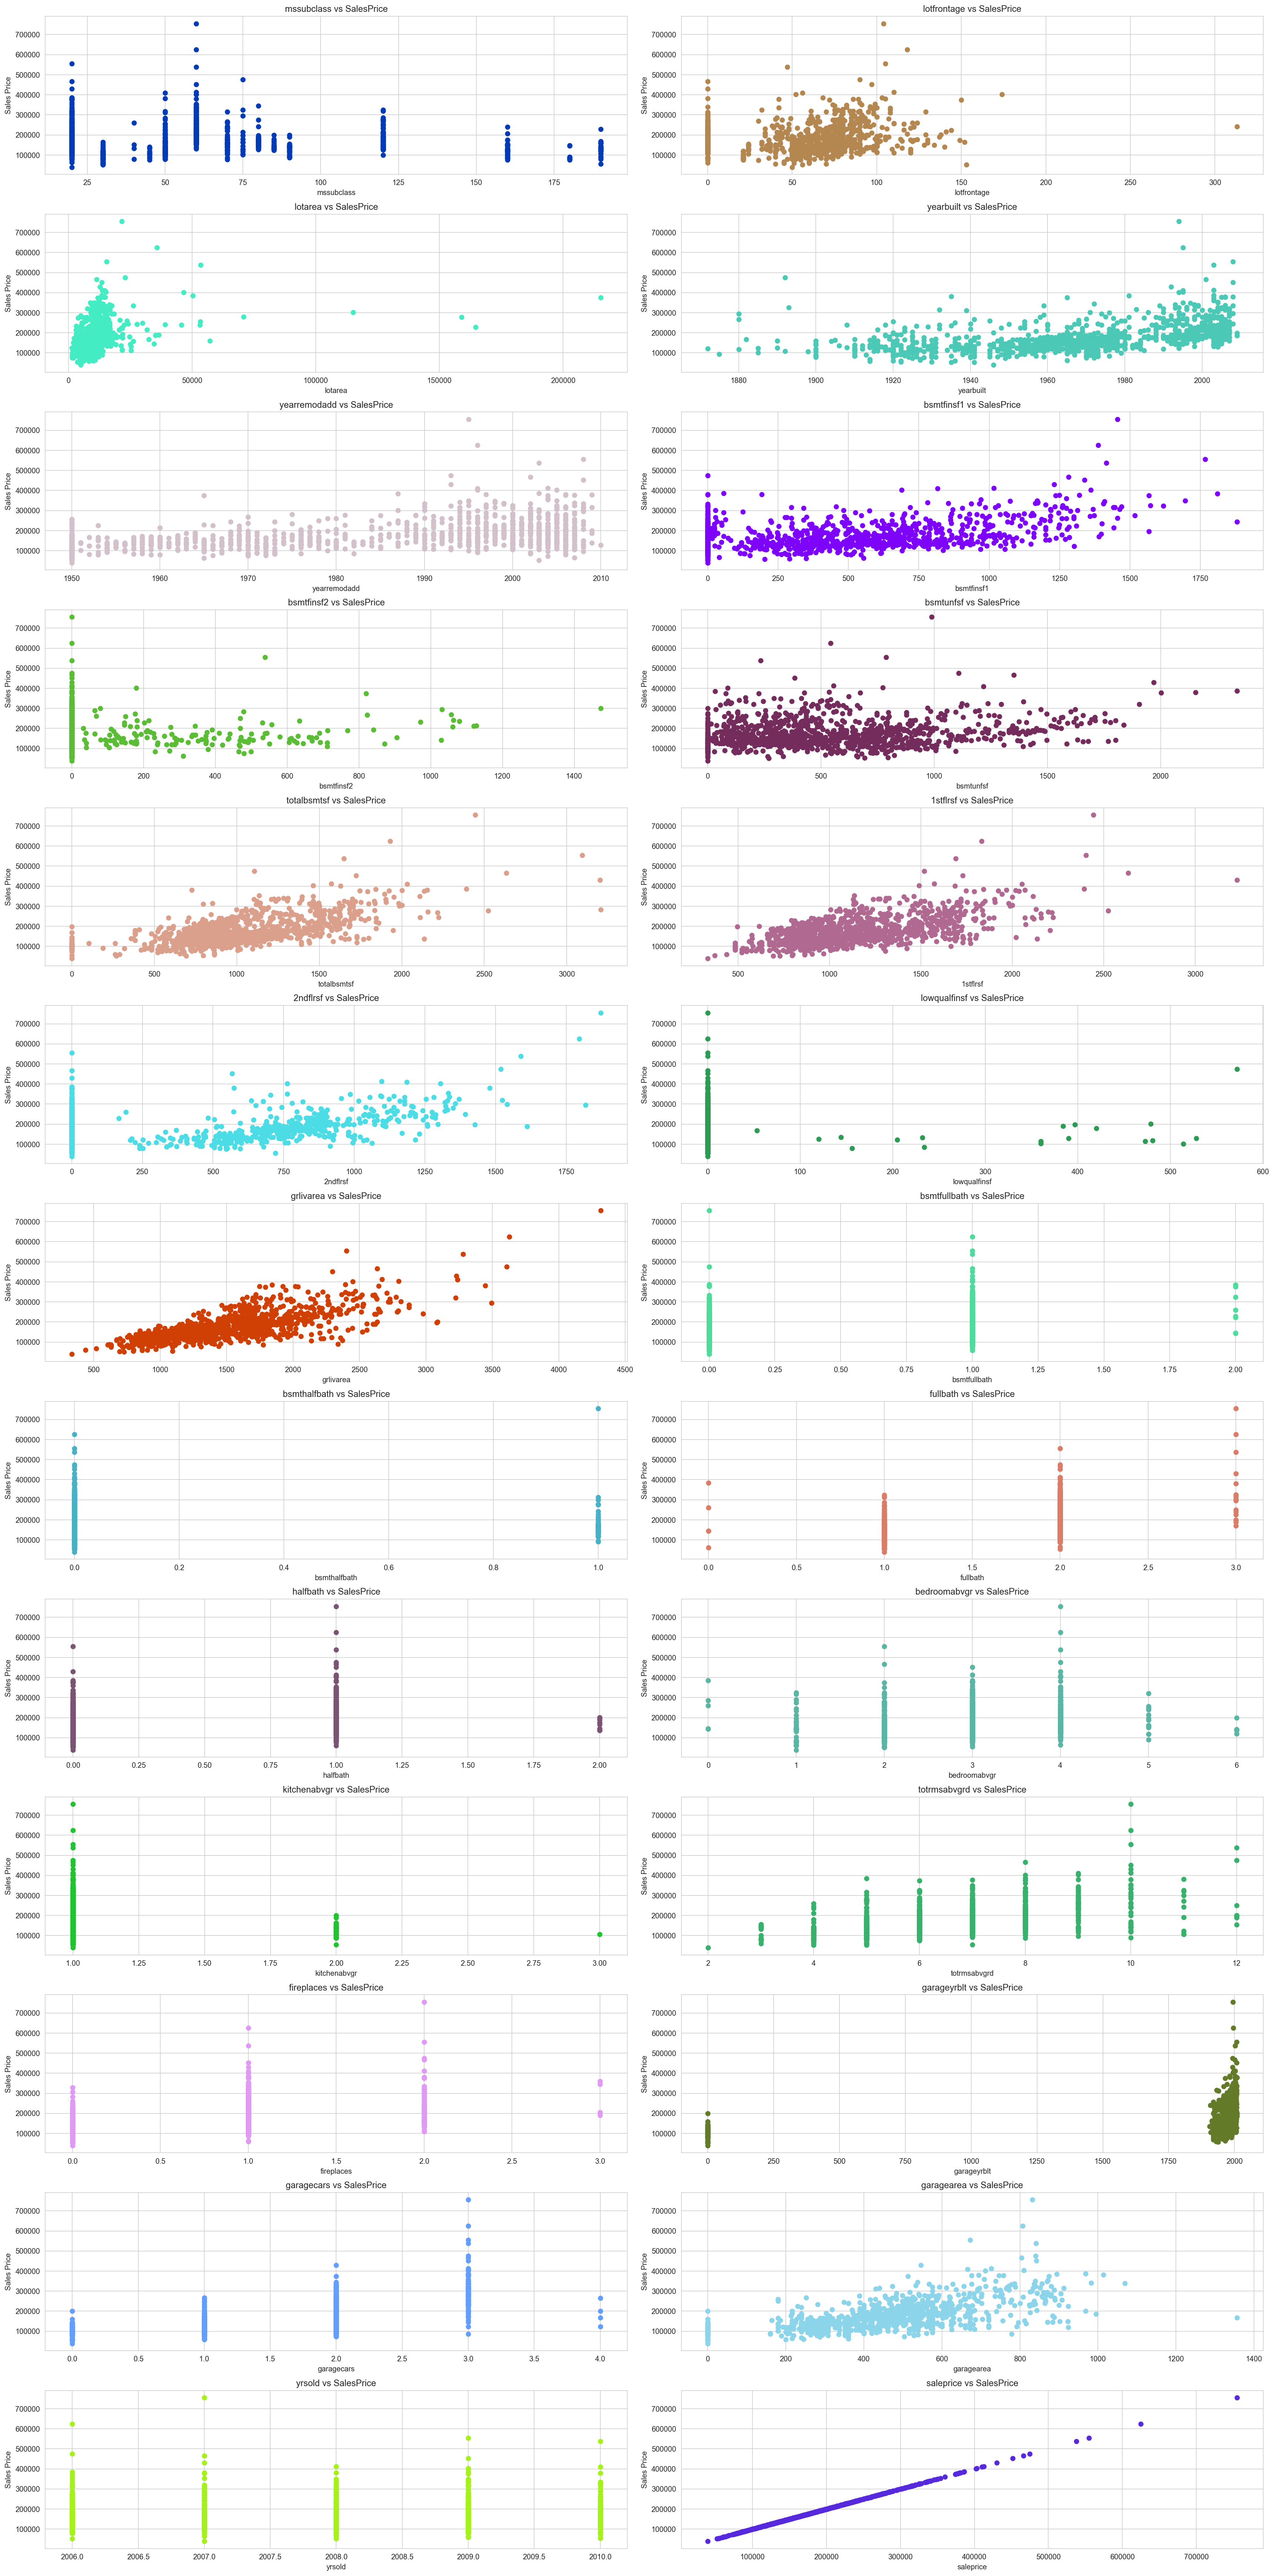

In [32]:
# Scatterplots for the numerical features:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

fig = plt.figure(figsize = (24,74))
i = 0

for col_names in fixed_num:
    i += 1
    fig.add_subplot(20,2,i)
    plt.scatter(fixed_num[col_names], Ames_fixed['saleprice'], c = np.random.rand(3,))
    plt.title(col_names + " vs SalesPrice")
    plt.xlabel(col_names)
    plt.ylabel('Sales Price')
    plt.legend

plt.tight_layout()
plt.show()



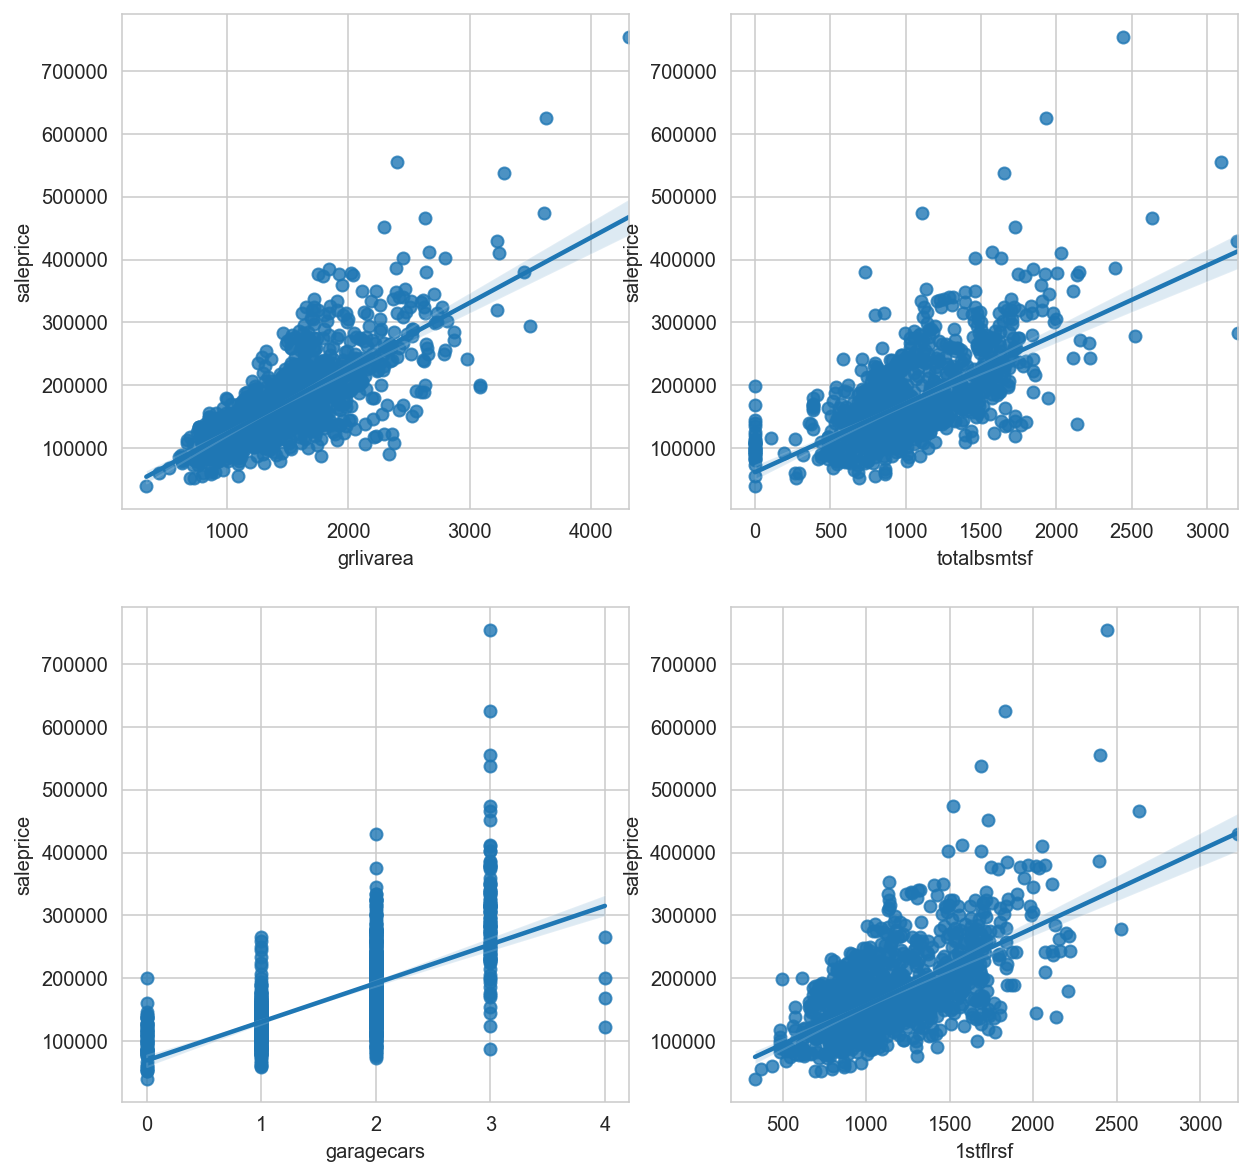

In [33]:
# Regression scatter plots for the top4 correlated numerical fixed characteristics:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
sns.regplot(x='grlivarea', y='saleprice', data=Ames_fixed, ax=axs[0,0])
sns.regplot(x='totalbsmtsf', y='saleprice', data=Ames_fixed, ax=axs[0,1])
sns.regplot(x='garagecars', y='saleprice', data=Ames_fixed, ax=axs[1,0])
sns.regplot(x='1stflrsf', y='saleprice', data=Ames_fixed, ax=axs[1,1])
plt.show()

#### `2.2.3` Training model

**<u> A. Dummifying our categorical features<u>**

We will include drop_first=True to deal with the anti-correlated columns:

In [34]:
fixed_cat_dum = pd.get_dummies(fixed_cat, drop_first=True)
fixed_cat_dum.head()

mszoning_RL  mszoning_RM  street_Pave  alley_NA  alley_Pave  lotshape_IR2  \
0            1            0            1         1           0             0   
1            1            0            1         1           0             0   
2            1            0            1         1           0             0   
4            1            0            1         1           0             0   
5            1            0            1         1           0             0   

   lotshape_IR3  lotshape_Reg  landcontour_HLS  landcontour_Low  ...  \
0             0             1                0                0  ...   
1             0             1                0                0  ...   
2             0             0                0                0  ...   
4             0             0                0                0  ...   
5             0             0                0                0  ...   

   bsmtqual_Ex  bsmtqual_Fa  bsmtqual_Gd  bsmtqual_TA  garagetype_2Types  \
0            0            0            1            0                  0   
1            0            0            1            0                  0   
2            0            0            1            0                  0   
4            0            0            1            0                  0   
5            0            0            1            0                  0   

   garagetype_Attchd  garagetype_Basment  garagetype_BuiltIn  \
0                  1                   0                   0   
1                  1                   0                   0   
2                  1                   0                   0   
4                  1                   0                   0   
5                  1                   0                   0   

   garagetype_CarPort  garagetype_Detchd  
0                   0                  0  
1                   0                  0  
2                   0                  0  
4                   0                  0  
5                   0                  0  

[5 rows x 81 columns]

In [35]:
# Verify that the number of features has been increased due to the dummy variables:
print('Number of features in original dataset, including categorical fields: ', fixed_cat.shape[1], 
      '\nNumber of features, including dummy variables for categorical fields: ', fixed_cat_dum.shape[1])

Number of features in original dataset, including categorical fields:  16 
Number of features, including dummy variables for categorical fields:  81


**<u>B. Merge & Train-test-split<u>**

In [36]:
Ames_final_copy = pd.concat([fixed_num.reset_index(drop=True), fixed_cat_dum.reset_index(drop=True)], axis=1)
#Ames_final.shape

The question states we must assign the train split of our machine learning algorithm as the pre-2010 data entries and thus use the 2010 entries and the test split. In order to do this we will split the data accordingly.

In [37]:
x_train = Ames_final_copy[Ames_final_copy.yrsold <2010]
y_train = x_train.pop('saleprice')
x_test = Ames_final_copy[Ames_final_copy.yrsold ==2010]
y_test= x_test.pop('saleprice')

**<u>C. Standardising the data<u>**

We will now standardise the categorical dummy variables in addition to the numerical ones. This has been done so we can conduct lasso and ridge models when carrying out regularisation later in this section.

In [38]:
scaler = StandardScaler()

x_train_std = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_test_std = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

**<u>D. Linear regression <u>**

In [39]:
# Initial fit:
model = LinearRegression()
model.fit(x_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
# Scores:
predictions =  model.predict(x_test_std)
score_train =  model.score(x_train_std, y_train)
score_test = model.score(x_test_std, y_test)
print(score_train, score_test)

0.9034284419944671 0.8779837257733184


In [41]:
# Perform 5-fold cross validation:
scores = cross_val_score(model, x_train_std, y_train, cv=5)
print("Cross-validated scores:", scores)
print("Mean of Cross-validated scores:", scores.mean())

Cross-validated scores: [-1.05501534e+26 -2.84269415e+15  8.74997685e-01 -2.09286895e+13
 -9.40490219e+14]
Mean of Cross-validated scores: -2.1100306767139475e+25


In [42]:
# Pulling and organising the coefficients:
cdf = pd.DataFrame({'variable': x_train_std.columns, 'coef': model.coef_})
cdf_sorted = cdf.sort_values(by=['coef'], ascending = False)

In [43]:
# Top 10:
cdf_sorted.head(10)

variable          coef
7             bsmtunfsf  1.393711e+16
5            bsmtfinsf1  1.372812e+16
12            grlivarea  8.936674e+15
6            bsmtfinsf2  5.339243e+15
101   garagetype_Attchd  3.572606e+04
105   garagetype_Detchd  3.289700e+04
103  garagetype_BuiltIn  1.675200e+04
3             yearbuilt  8.951552e+03
2               lotarea  8.815593e+03
4          yearremodadd  7.724944e+03

In [44]:
# Bottom 10:
cdf_sorted.tail(10)

variable          coef
52  neighborhood_Mitchel -5.127750e+03
17          bedroomabvgr -5.145000e+03
53    neighborhood_NAmes -5.481750e+03
99           bsmtqual_TA -1.628038e+04
21           garageyrblt -1.783650e+04
98           bsmtqual_Gd -1.793406e+04
11          lowqualfinsf -8.867794e+14
9               1stflrsf -6.306437e+15
10              2ndflrsf -7.706888e+15
8            totalbsmtsf -1.356127e+16

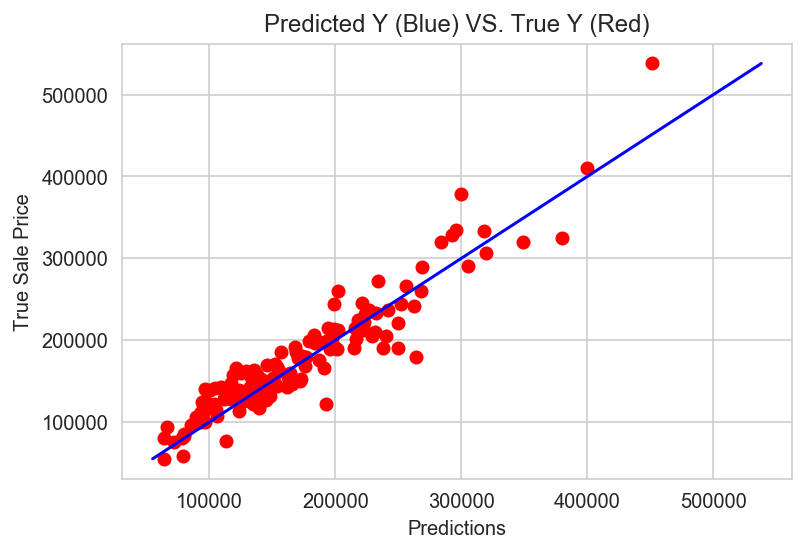

In [45]:
# Plotting predicted y against true y:
plt.scatter(predictions, y_test, c = 'r')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c = 'blue')
plt.xlabel('Predictions')
plt.ylabel('True Sale Price')
plt.title('Predicted Y (Blue) VS. True Y (Red)')
plt.show()

We can see our linear regression model highlights features such as **grlivarea** and **totalbsmtsf** as great predictors.

**<u>E. Setting up regularisation<u>**

We will now introduce ridge and lasso regression in an attempt to reduce model complexity and prevent  any overfitting that may have occured from linear regression. 

To speed up the process of evaluating the different models we will introduce a concise function that will generate:
- cv score
- training set score
- test set score

In [46]:
def scores_calculator(model, X_train, y_train, X_test, y_test, cv=5):
    """Evaluates the inputted model and outputs various scores"""
    model.fit(X_train, y_train)
    cv_score = (np.mean(cross_val_score(model, X_train, y_train, cv=cv)))
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return cv_score, training_score, test_score

In [47]:
# Ridge method:
ridge = Ridge(alpha=1)
cv, train, test = scores_calculator(ridge, x_train_std, y_train, x_test_std, y_test)
print(f'CV Score is {cv}, Training Score is {train}, Test Score is {test}')

CV Score is 0.859784456798874, Training Score is 0.9033858451074317, Test Score is 0.8784677266072953


In [48]:
# Lasso method:
lasso = Lasso(alpha=0.01, max_iter =1000000)
cv, train, test = scores_calculator(lasso, x_train_std, y_train, x_test_std, y_test)
print(f'CV Score is {cv}, Training Score is {train}, Test Score is {test}')

CV Score is 0.8592901795915916, Training Score is 0.9034302977145736, Test Score is 0.8779847457445589


In [49]:
# Elastic method:
elastic = ElasticNet(alpha=0.1, l1_ratio=0.05)
cv, train, test = scores_calculator(elastic, x_train_std, y_train, x_test_std, y_test)
print(f'CV Score is {cv}, Training Score is {train}, Test Score is {test}')

CV Score is 0.8621232612538499, Training Score is 0.8977942209052066, Test Score is 0.8787880857790162


**<u>F. Cross-validating regularisation models <u>**
    
`Ridge`

In [50]:
ridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 100), cv=5)
ridge_cv.fit(x_train_std, y_train)
print(ridge_cv.alpha_)

46.41588833612782


In [51]:
ridge_cv.score(x_test_std, y_test)

0.8792011486911445

---

`Lasso`

In [52]:
lasso_cv = LassoCV(alphas=np.logspace(-5, 5, 100), cv=5, max_iter=1000000)
lasso_cv.fit(x_train_std, y_train)
print(lasso_cv.alpha_)

475.0810162102793


In [53]:
Lasso(alpha = 475.0810162102793 )

Lasso(alpha=475.0810162102793, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [54]:
lasso_cv.score(x_test_std, y_test)

0.8809728955477517

---

`Elasticnet`

In [55]:
ela_cv = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100), cv=5, max_iter = 1000000)
ela_cv.fit(x_train_std, y_train)
print(ela_cv.alpha_)
print(ela_cv.l1_ratio_)

475.0810162102793
1.0


In [56]:
ela_cv.score(x_test_std, y_test)

0.8809728955477517

**<u>F. Visualising regularisation models<u>**

`Ridge`

In [57]:
ridge_cvdf = pd.DataFrame({'variables': x_train_std.columns, 'coef': ridge_cv.coef_})
ridge_cvdfs = ridge_cvdf.sort_values('coef')

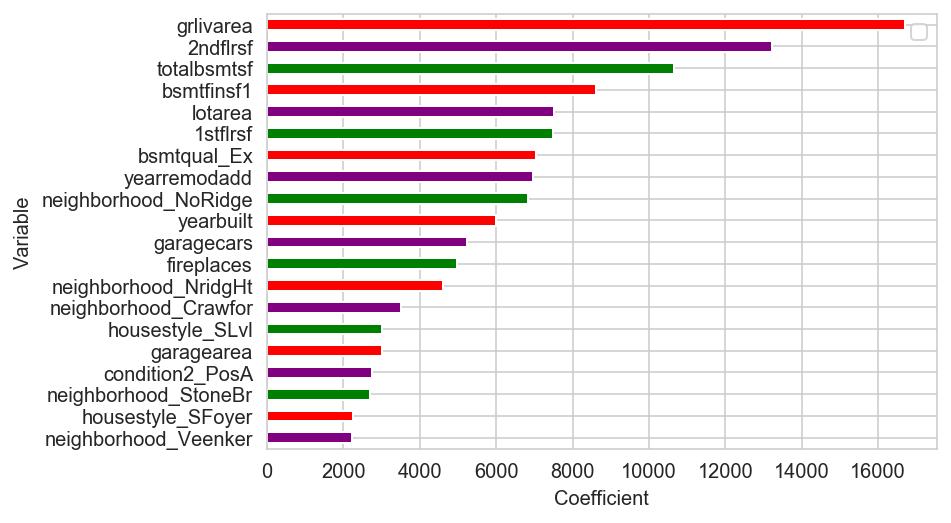

In [58]:
ridge_cvdfs.tail(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['purple', 'red', 'green'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

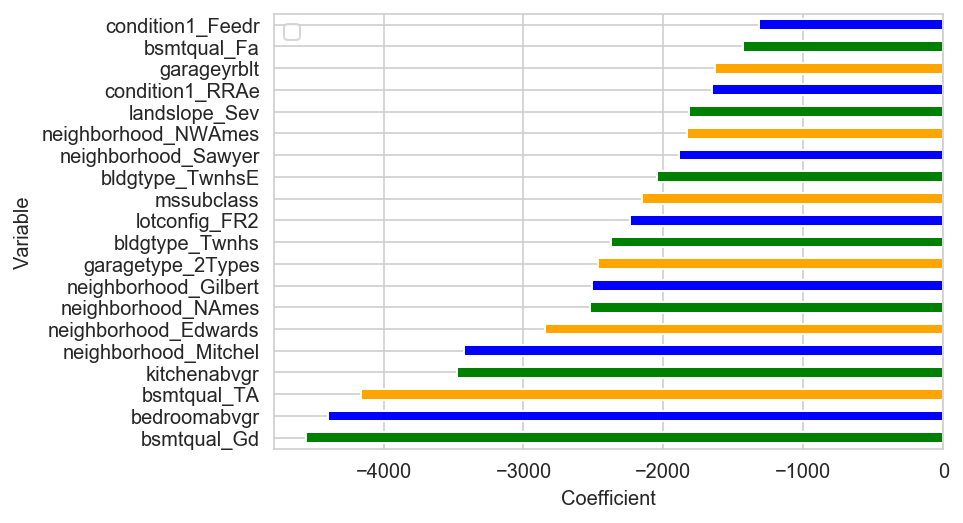

In [59]:
ridge_cvdfs.head(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['green', 'blue', 'orange'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

In [60]:
def regular__plotter(y_test, predictions):
    residuals = y_test - predictions 
    fig, ax = plt.subplots(ncols = 2, figsize=(15,5))
    ax[0].hist(residuals, bins = 25)
    ax[0].set_title('Residuals')
    ax[1].scatter(predictions, y_test, c = 'r')
    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c = 'blue')
    ax[1].set_title('Predicted VS True Values')
    plt.show()

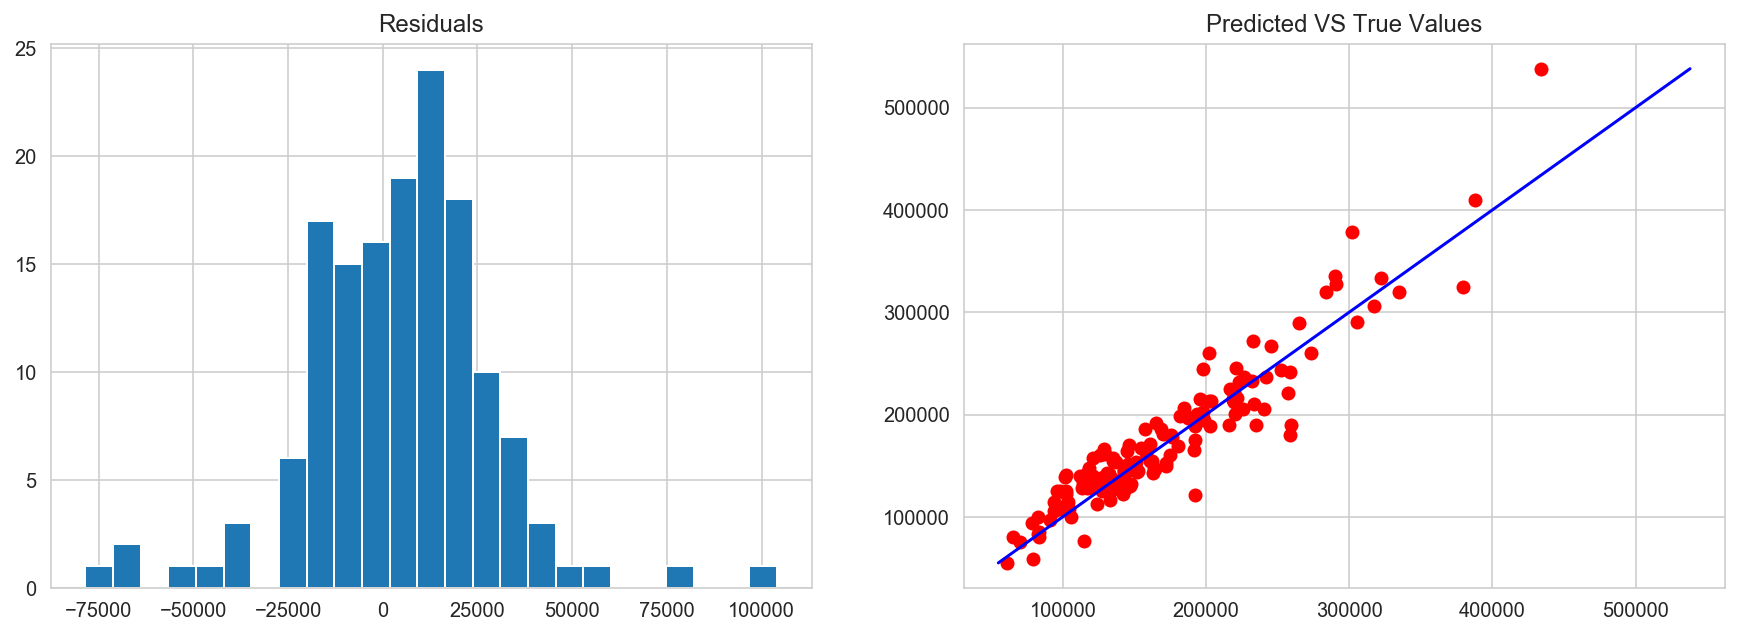

In [61]:
regular__plotter(y_test, ridge_cv.predict(x_test_std))

---

`Lasso`

In [62]:
lasso_cvdf = pd.DataFrame({'variables': x_train_std.columns, 'coef': lasso_cv.coef_})
lasso_cvdfs = lasso_cvdf.sort_values('coef')

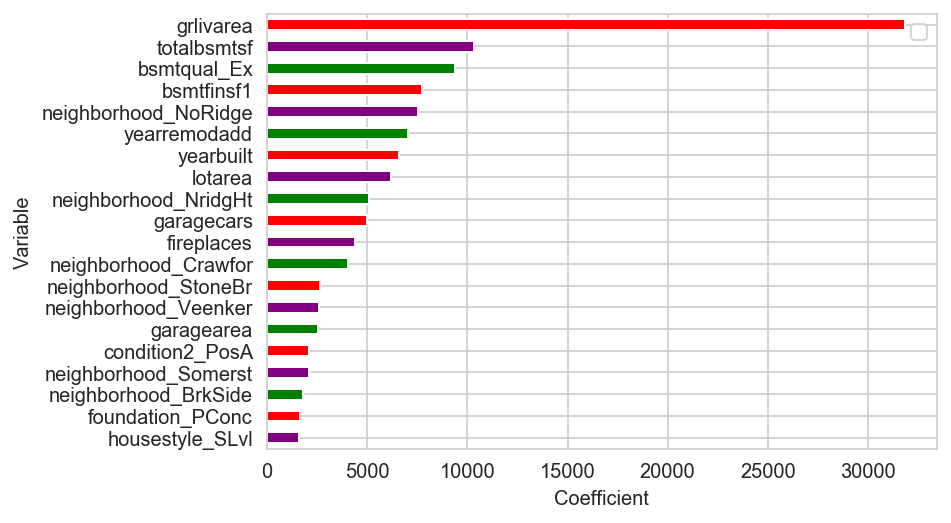

In [63]:
lasso_cvdfs.tail(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['purple', 'red', 'green'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

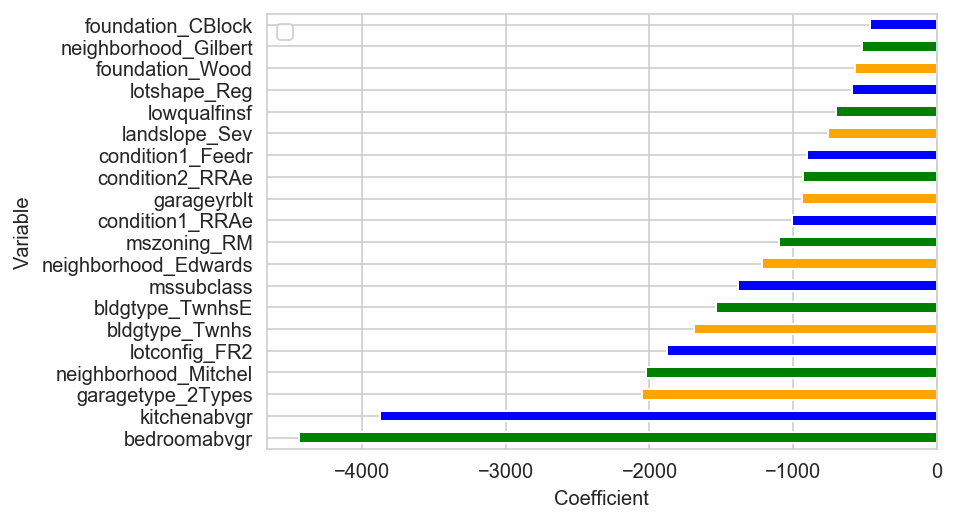

In [64]:
lasso_cvdfs.head(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['green', 'blue', 'orange'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

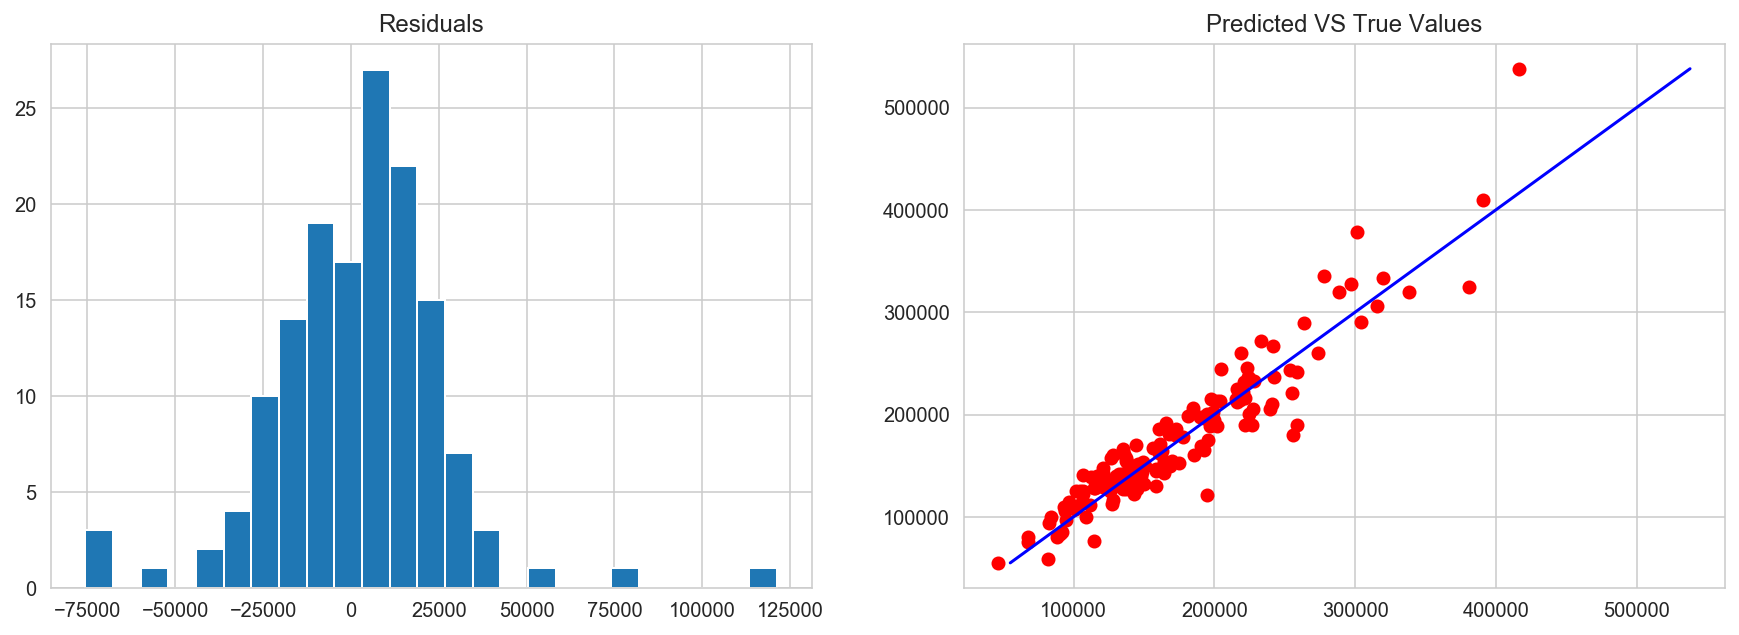

In [65]:
regular__plotter(y_test, lasso_cv.predict(x_test_std))

---

`Elastic`

In [66]:
ela_cvdf = pd.DataFrame({'variables': x_train_std.columns, 'coef': ela_cv.coef_})
ela_cvdfs = ela_cvdf.sort_values('coef')

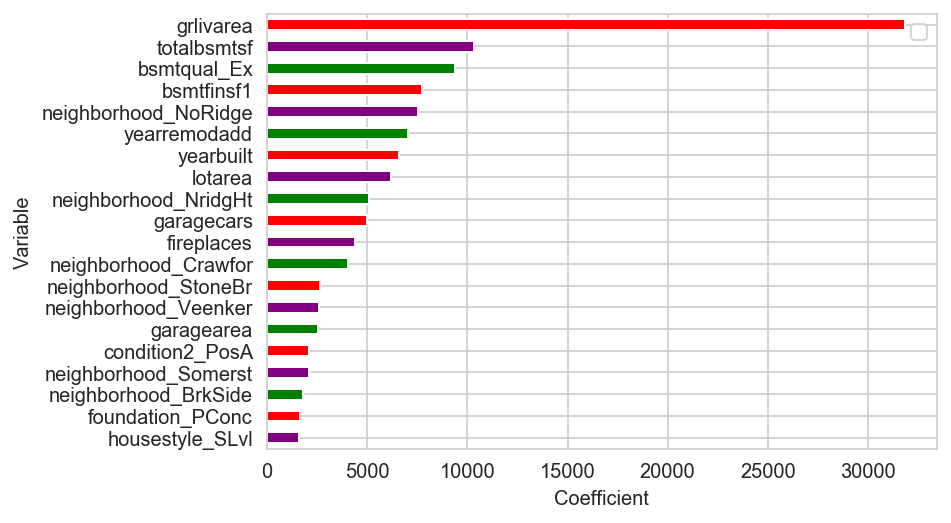

In [67]:
ela_cvdfs.tail(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['purple', 'red', 'green'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

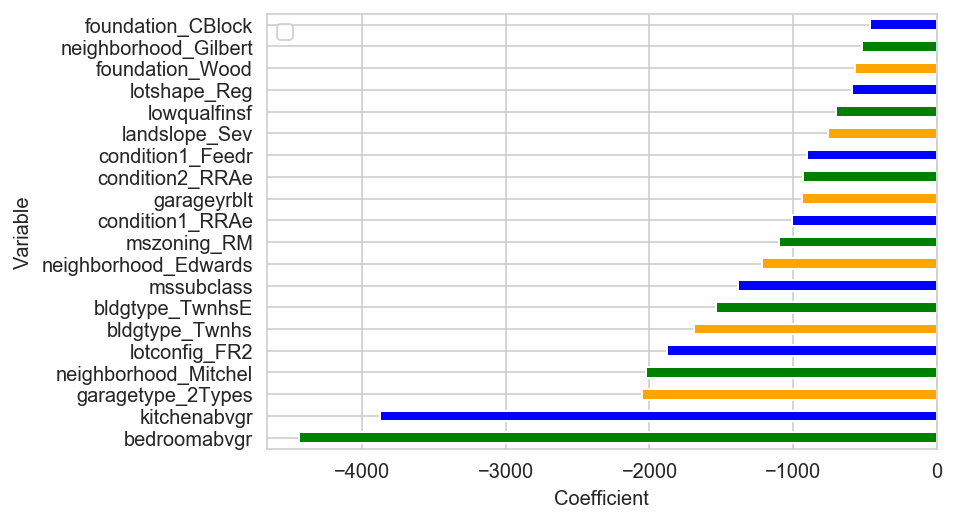

In [68]:
ela_cvdfs.head(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['green', 'blue', 'orange'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

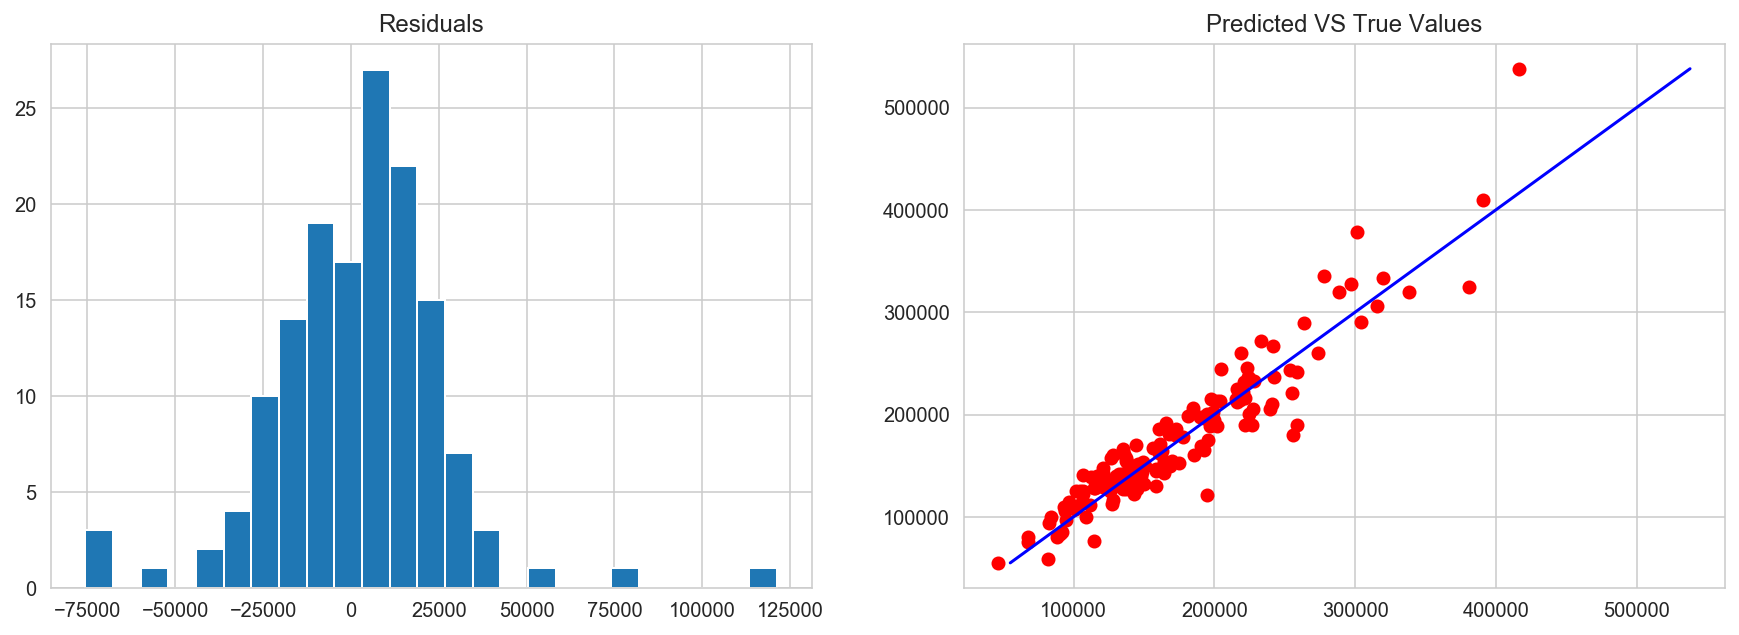

In [69]:
regular__plotter(y_test, ela_cv.predict(x_test_std))

#### `2.2.4` Characterising the model

We will pick ridge to use as our model due to the features with the highest coefficients, grlivarea (above grade ground living area square feet) and 2ndflrsf (second floor square feet), making the most sense as strong predictors of house prices. 

At the opposite end we can see some of the features are heavily negatively correlated. In particular bsmtqualgd (a basement with a higher height of 90-99 inches is negatively correlated with sale price). 

It is clear that all three models have been succesful with scores all nearing 0.88. Additionally the features which have been deemed to be the strongest price predictors make sense so we can believe they have been succcesfully calculated.

## `3` Determine any value of changeable property characteristics unexplained by the fixed ones

### `3.1` Problem

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

---

### `3.2` Solution

#### `3.2.1` Performing EDA on unfixed 

**<u>A. Setting up<u>**

- We will add **yrsold** to the unfixed features in order to split the data into pre 2010 and 2010 as required for a further part of this question.
- Also we will removed the **electrical** feature since nearly all entries are Standard Circuit Breakers & Romex.

In [70]:
unfixed = [
    '3ssnporch', 'salecondition', 'miscfeature', 'screenporch', 'functional',
    'garagecond', 'poolqc', 'fence', 'heating', 'masvnrtype', 'bsmtexposure',
    'utilities', 'fireplacequ', 'bsmtfintype1', 'exterqual', 'exterior1st',
    'exterior2nd', 'roofstyle', 'kitchenqual', 'miscval', 'masvnrarea',
    'enclosedporch', 'centralair', 'garagequal', 'bsmtfintype2', 'openporchsf',
    'heatingqc', 'wooddecksf', 'paveddrive', 'overallcond', 'poolarea',
    'bsmtcond', 'garagefinish', 'roofmatl', 'extercond',
    'overallqual', 'yrsold', 'mszoning'
]

In [71]:
Ames_unfixed = Ames[unfixed].copy()

**<u>B. Dealing with NaN values<u>**

In [72]:
missing_count = pd.DataFrame(Ames_unfixed.isna().sum().sort_values(ascending=False), columns=['fixed'])
missing_chars = missing_count[missing_count['fixed'] >= 1]
missing_chars

fixed
poolqc         1152
miscfeature    1106
fence           916
fireplacequ     536
garagequal       61
garagefinish     61
garagecond       61
bsmtexposure     33
bsmtfintype2     33
bsmtfintype1     32
bsmtcond         32
masvnrarea        3
masvnrtype        3

In [73]:
Ames_unfixed[missing_chars.index].head(10)

poolqc miscfeature  fence fireplacequ garagequal garagefinish garagecond  \
0     NaN         NaN    NaN         NaN         TA          RFn         TA   
1     NaN         NaN    NaN          TA         TA          RFn         TA   
2     NaN         NaN    NaN          TA         TA          RFn         TA   
4     NaN         NaN    NaN          TA         TA          RFn         TA   
5     NaN        Shed  MnPrv         NaN         TA          Unf         TA   
6     NaN         NaN    NaN          Gd         TA          RFn         TA   
7     NaN        Shed    NaN          TA         TA          RFn         TA   
9     NaN         NaN    NaN          TA         Gd          RFn         TA   
10    NaN         NaN    NaN         NaN         TA          Unf         TA   
12    NaN         NaN    NaN         NaN         TA          Unf         TA   

   bsmtexposure bsmtfintype2 bsmtfintype1 bsmtcond  masvnrarea masvnrtype  
0            No          Unf          GLQ       TA       196.0    BrkFace  
1            Gd          Unf          ALQ       TA         0.0       None  
2            Mn          Unf          GLQ       TA       162.0    BrkFace  
4            Av          Unf          GLQ       TA       350.0    BrkFace  
5            No          Unf          GLQ       TA         0.0       None  
6            Av          Unf          GLQ       TA       186.0      Stone  
7            Mn          BLQ          ALQ       TA       240.0      Stone  
9            No          Unf          GLQ       TA         0.0       None  
10           No          Unf          Rec       TA         0.0       None  
12           No          Unf          ALQ       TA         0.0       None

In [74]:
# poolqc:
print(Ames_unfixed.poolqc.unique())

# Data_description indicates nan is no pool at property (Np).
# Replace nan with NA. 
Ames_unfixed.poolqc.fillna('Np', inplace = True)
print(Ames_unfixed.poolqc.unique())

[nan 'Fa' 'Gd']
['Np' 'Fa' 'Gd']


In [75]:
# miscfeature:
print(Ames_unfixed.miscfeature.unique())

# Data_description indicates nan is no misc feature at property (NMF).
# Replace nan with NMF. 
Ames_unfixed.miscfeature.fillna('NMF', inplace = True)
print(Ames_unfixed.miscfeature.unique())

[nan 'Shed' 'Gar2' 'Othr' 'TenC']
['NMF' 'Shed' 'Gar2' 'Othr' 'TenC']


In [76]:
# fence:
print(Ames_unfixed.fence.unique())

# Data_description indicates nan is no fence at property (NF).
# Replace nan with NF. 
Ames_unfixed.fence.fillna('NF', inplace = True)
print(Ames_unfixed.fence.unique())

[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
['NF' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [77]:
# fireplacequ:
print(Ames_unfixed.fireplacequ.unique())

# Data_description indicates nan is no fireplace at property (NFP).
# Replace nan with NFP. 
Ames_unfixed.fireplacequ.fillna('NFP', inplace = True)
print(Ames_unfixed.fireplacequ.unique())

[nan 'TA' 'Gd' 'Fa' 'Po' 'Ex']
['NFP' 'TA' 'Gd' 'Fa' 'Po' 'Ex']


In [111]:
# garagefinish:
print(Ames_unfixed.garagefinish.unique())

# Data_description indicates nan is no garage at property (NG).
# Replace nan with NG. 
Ames_unfixed.garagefinish.fillna('NFP', inplace = True)
print(Ames_unfixed.garagefinish.unique())

['RFn' 'Unf' 'Fin' 'NG']
['RFn' 'Unf' 'Fin' 'NG']


In [79]:
# garagecond:
print(Ames_unfixed.garagecond.unique())

# Data_description indicates nan is no garage at property (NG).
# Replace nan with NG. 
Ames_unfixed.garagecond.fillna('NG', inplace = True)
print(Ames_unfixed.garagecond.unique())

['TA' 'Gd' nan 'Fa' 'Po' 'Ex']
['TA' 'Gd' 'NG' 'Fa' 'Po' 'Ex']


In [80]:
# garagequal:
print(Ames_unfixed.garagequal.unique())

# Data_description indicates nan is no garage at property (NG).
# Replace nan with NG. 
Ames_unfixed.garagequal.fillna('NG', inplace = True)
print(Ames_unfixed.garagequal.unique())

['TA' 'Gd' 'Fa' nan 'Ex' 'Po']
['TA' 'Gd' 'Fa' 'NG' 'Ex' 'Po']


In [81]:
# bsmtexposure:
print(Ames_unfixed.bsmtexposure.unique())

# Data_description indicates nan is no basement at property (NB).
# Replace nan with NB. 
Ames_unfixed.bsmtexposure.fillna('NB', inplace = True)
print(Ames_unfixed.bsmtexposure.unique())

['No' 'Gd' 'Mn' 'Av' nan]
['No' 'Gd' 'Mn' 'Av' 'NB']


In [82]:
# bsmtfintype2:
print(Ames_unfixed.bsmtfintype2.unique())

# Data_description indicates nan is no basement at property (NB).
# Replace nan with NB. 
Ames_unfixed.bsmtfintype2.fillna('NB', inplace = True)
print(Ames_unfixed.bsmtfintype2.unique())

['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Unf' 'BLQ' 'NB' 'ALQ' 'Rec' 'LwQ' 'GLQ']


In [83]:
# bsmtfintype1:
print(Ames_unfixed.bsmtfintype1.unique())

# Data_description indicates nan is no basement at property (NB).
# Replace nan with NG. 
Ames_unfixed.bsmtfintype1.fillna('NB', inplace = True)
print(Ames_unfixed.bsmtfintype1.unique())

['GLQ' 'ALQ' 'Rec' 'BLQ' 'Unf' nan 'LwQ']
['GLQ' 'ALQ' 'Rec' 'BLQ' 'Unf' 'NB' 'LwQ']


In [84]:
# bsmtcond:
print(Ames_unfixed.bsmtcond.unique())

# Data_description indicates nan is no basement at property (NB).
# Replace nan with NB. 
Ames_unfixed.bsmtcond.fillna('NB', inplace = True)
print(Ames_unfixed.bsmtcond.unique())

['TA' nan 'Fa' 'Gd' 'Po']
['TA' 'NB' 'Fa' 'Gd' 'Po']


In [85]:
# masvnrtype:
print(Ames_unfixed.masvnrtype.unique())

# Data_description indicates nan is no veneer at property (NV).
# Replace nan with NV. 
Ames_unfixed.masvnrtype.fillna('NV', inplace = True)
print(Ames_unfixed.masvnrtype.unique())

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['BrkFace' 'None' 'Stone' 'BrkCmn' 'NV']


In [86]:
# masvnrarea:
print(Ames_unfixed.masvnrarea.isnull().value_counts())

# Data_description indicates nan is no veneer (in sqft) at property.
# Replace nan with 0. 
Ames_unfixed.masvnrarea.fillna(0, inplace = True)
print(Ames_unfixed.masvnrarea.isnull().value_counts())

False    1152
True        3
Name: masvnrarea, dtype: int64
False    1155
Name: masvnrarea, dtype: int64


**<u>C. Splitting the data into numerical & categorical<u>**

In [87]:
# Breaking the dataframe into categorical data we see there are 27 columns.
unfixed_cat = Ames_unfixed.select_dtypes(include=['object'])
unfixed_cat.shape

(1155, 27)

In [88]:
# Breaking the dataframe into numerical data we see there are 11 columns.
unfixed_num = Ames_unfixed.select_dtypes(include=['int64','float64'])
unfixed_num.shape

(1155, 11)

**<u>E. Visualisations<u>**
    
*Overview of distributions for numerical variables using histograms:*

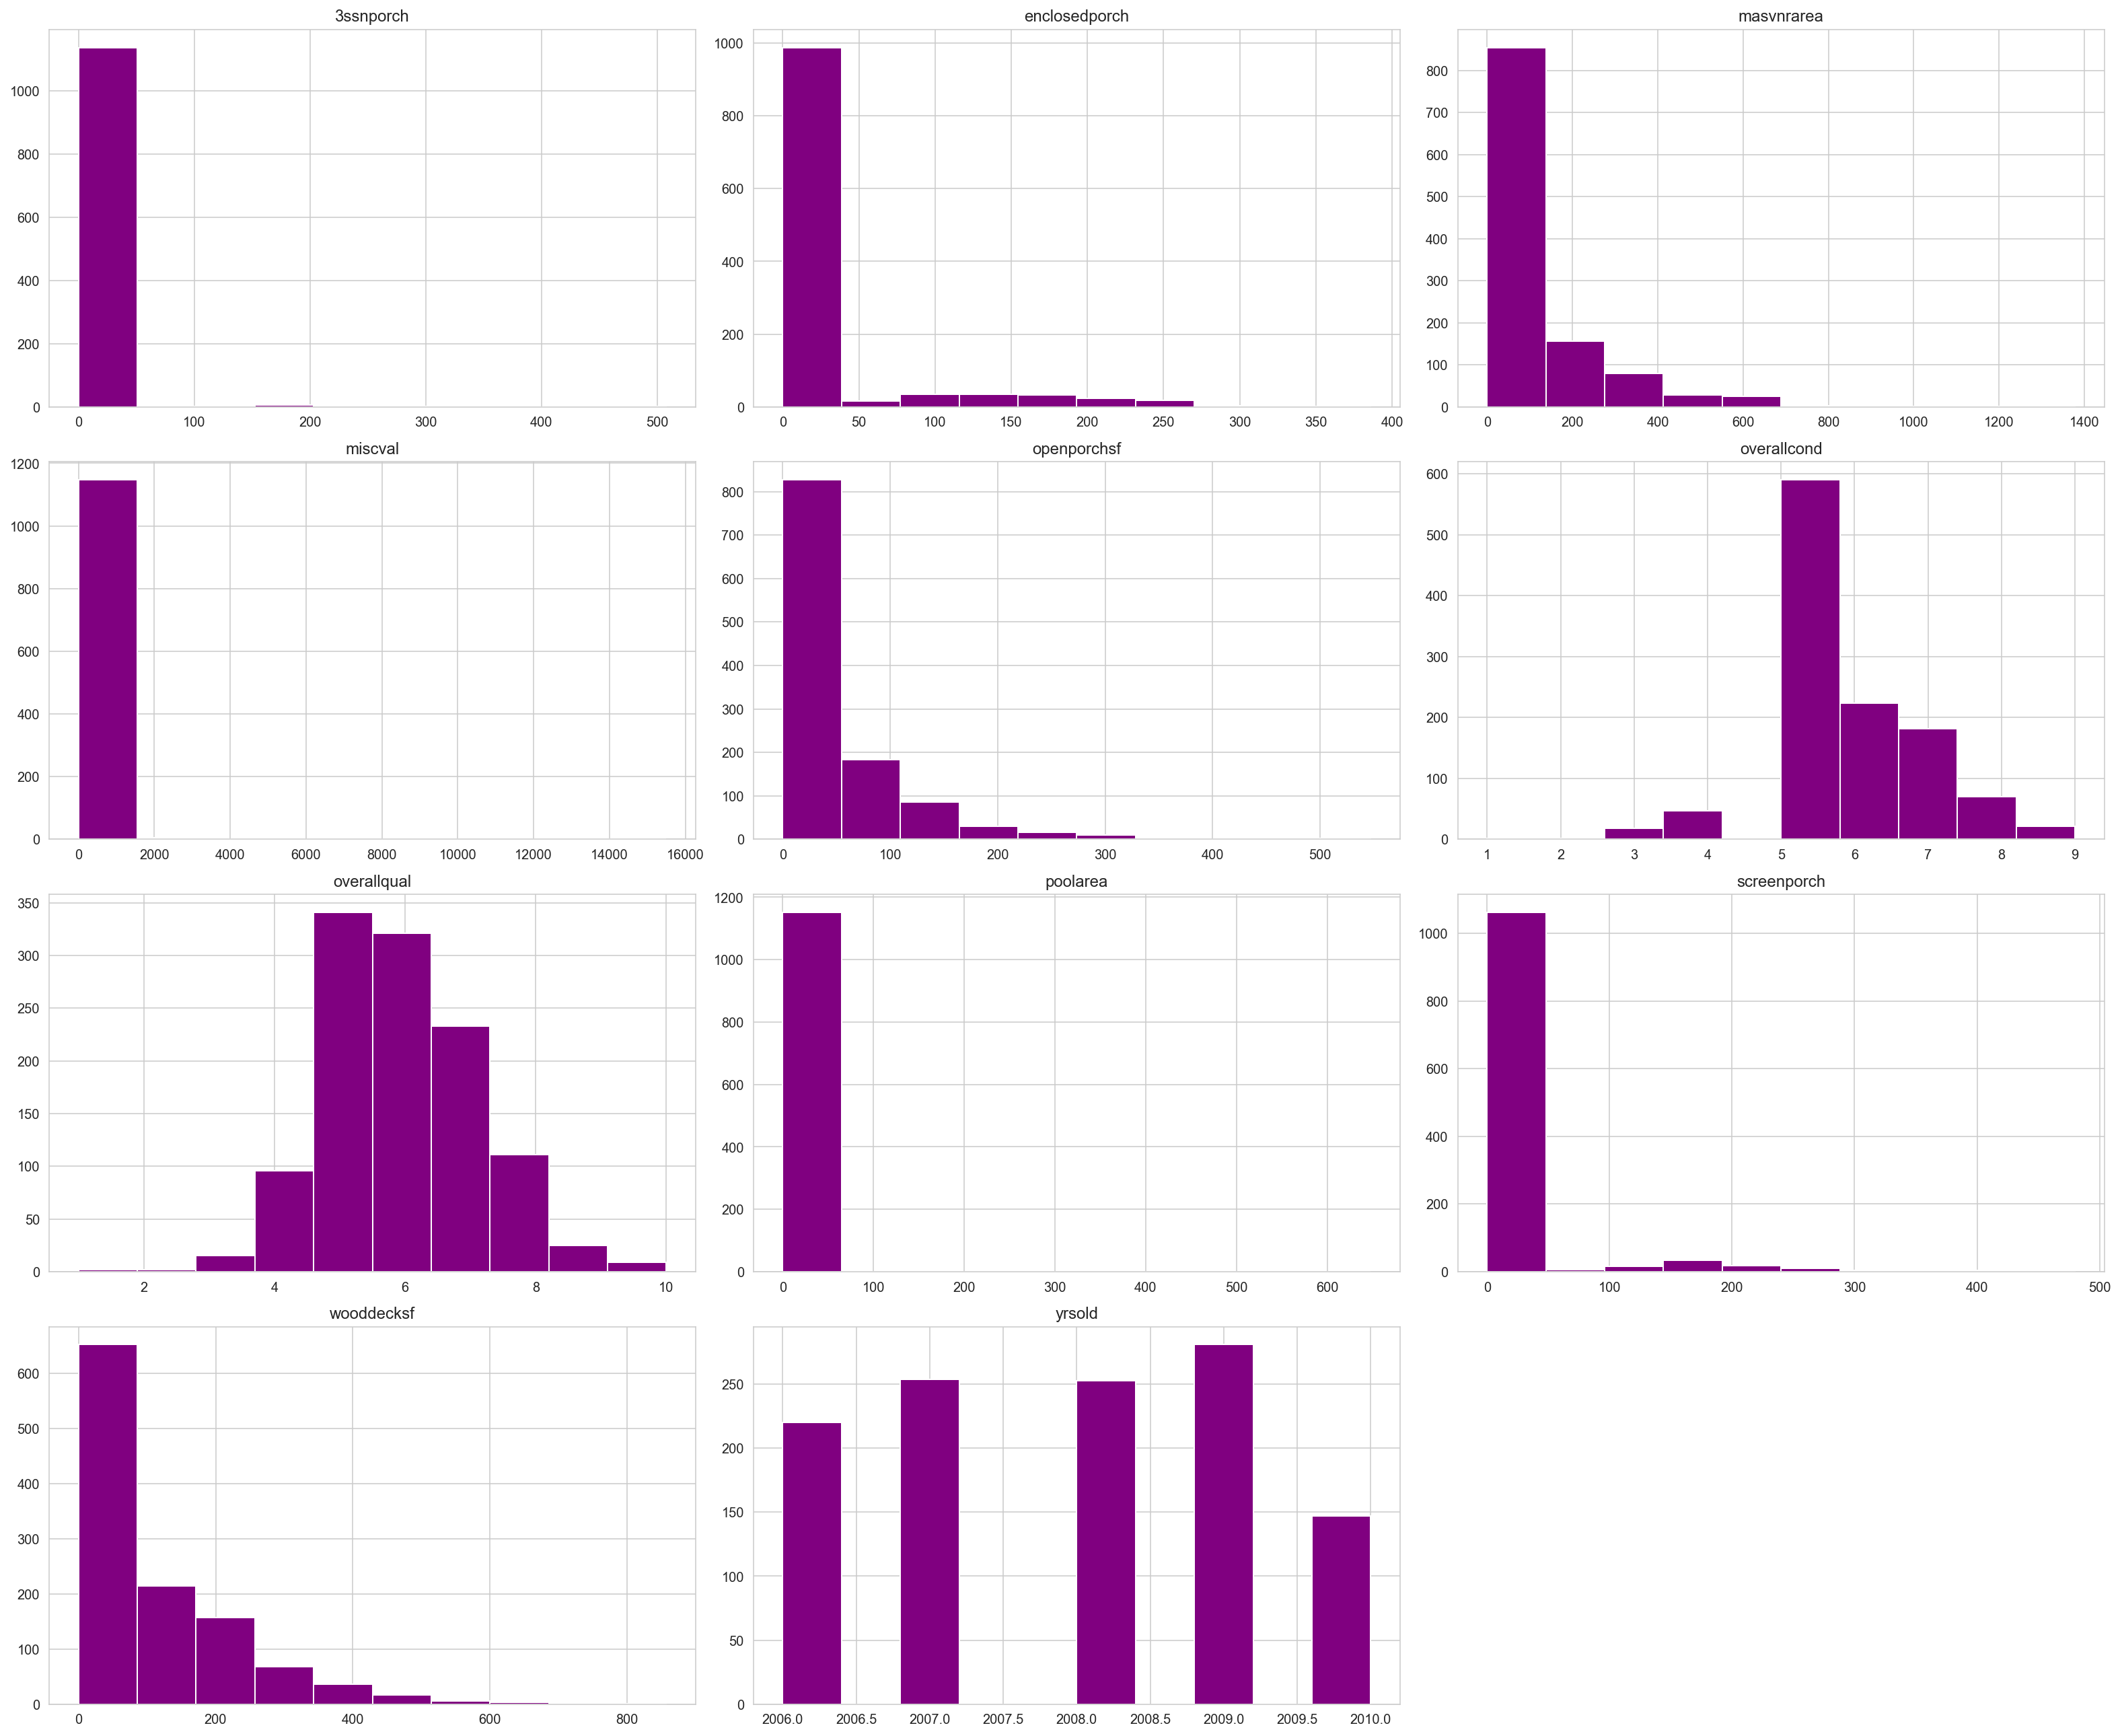

In [89]:
ax = unfixed_num.hist(figsize=(22,18), color = 'purple')
plt.tight_layout()
plt.show()

*Overview of distributions for categorical variables using histograms:*

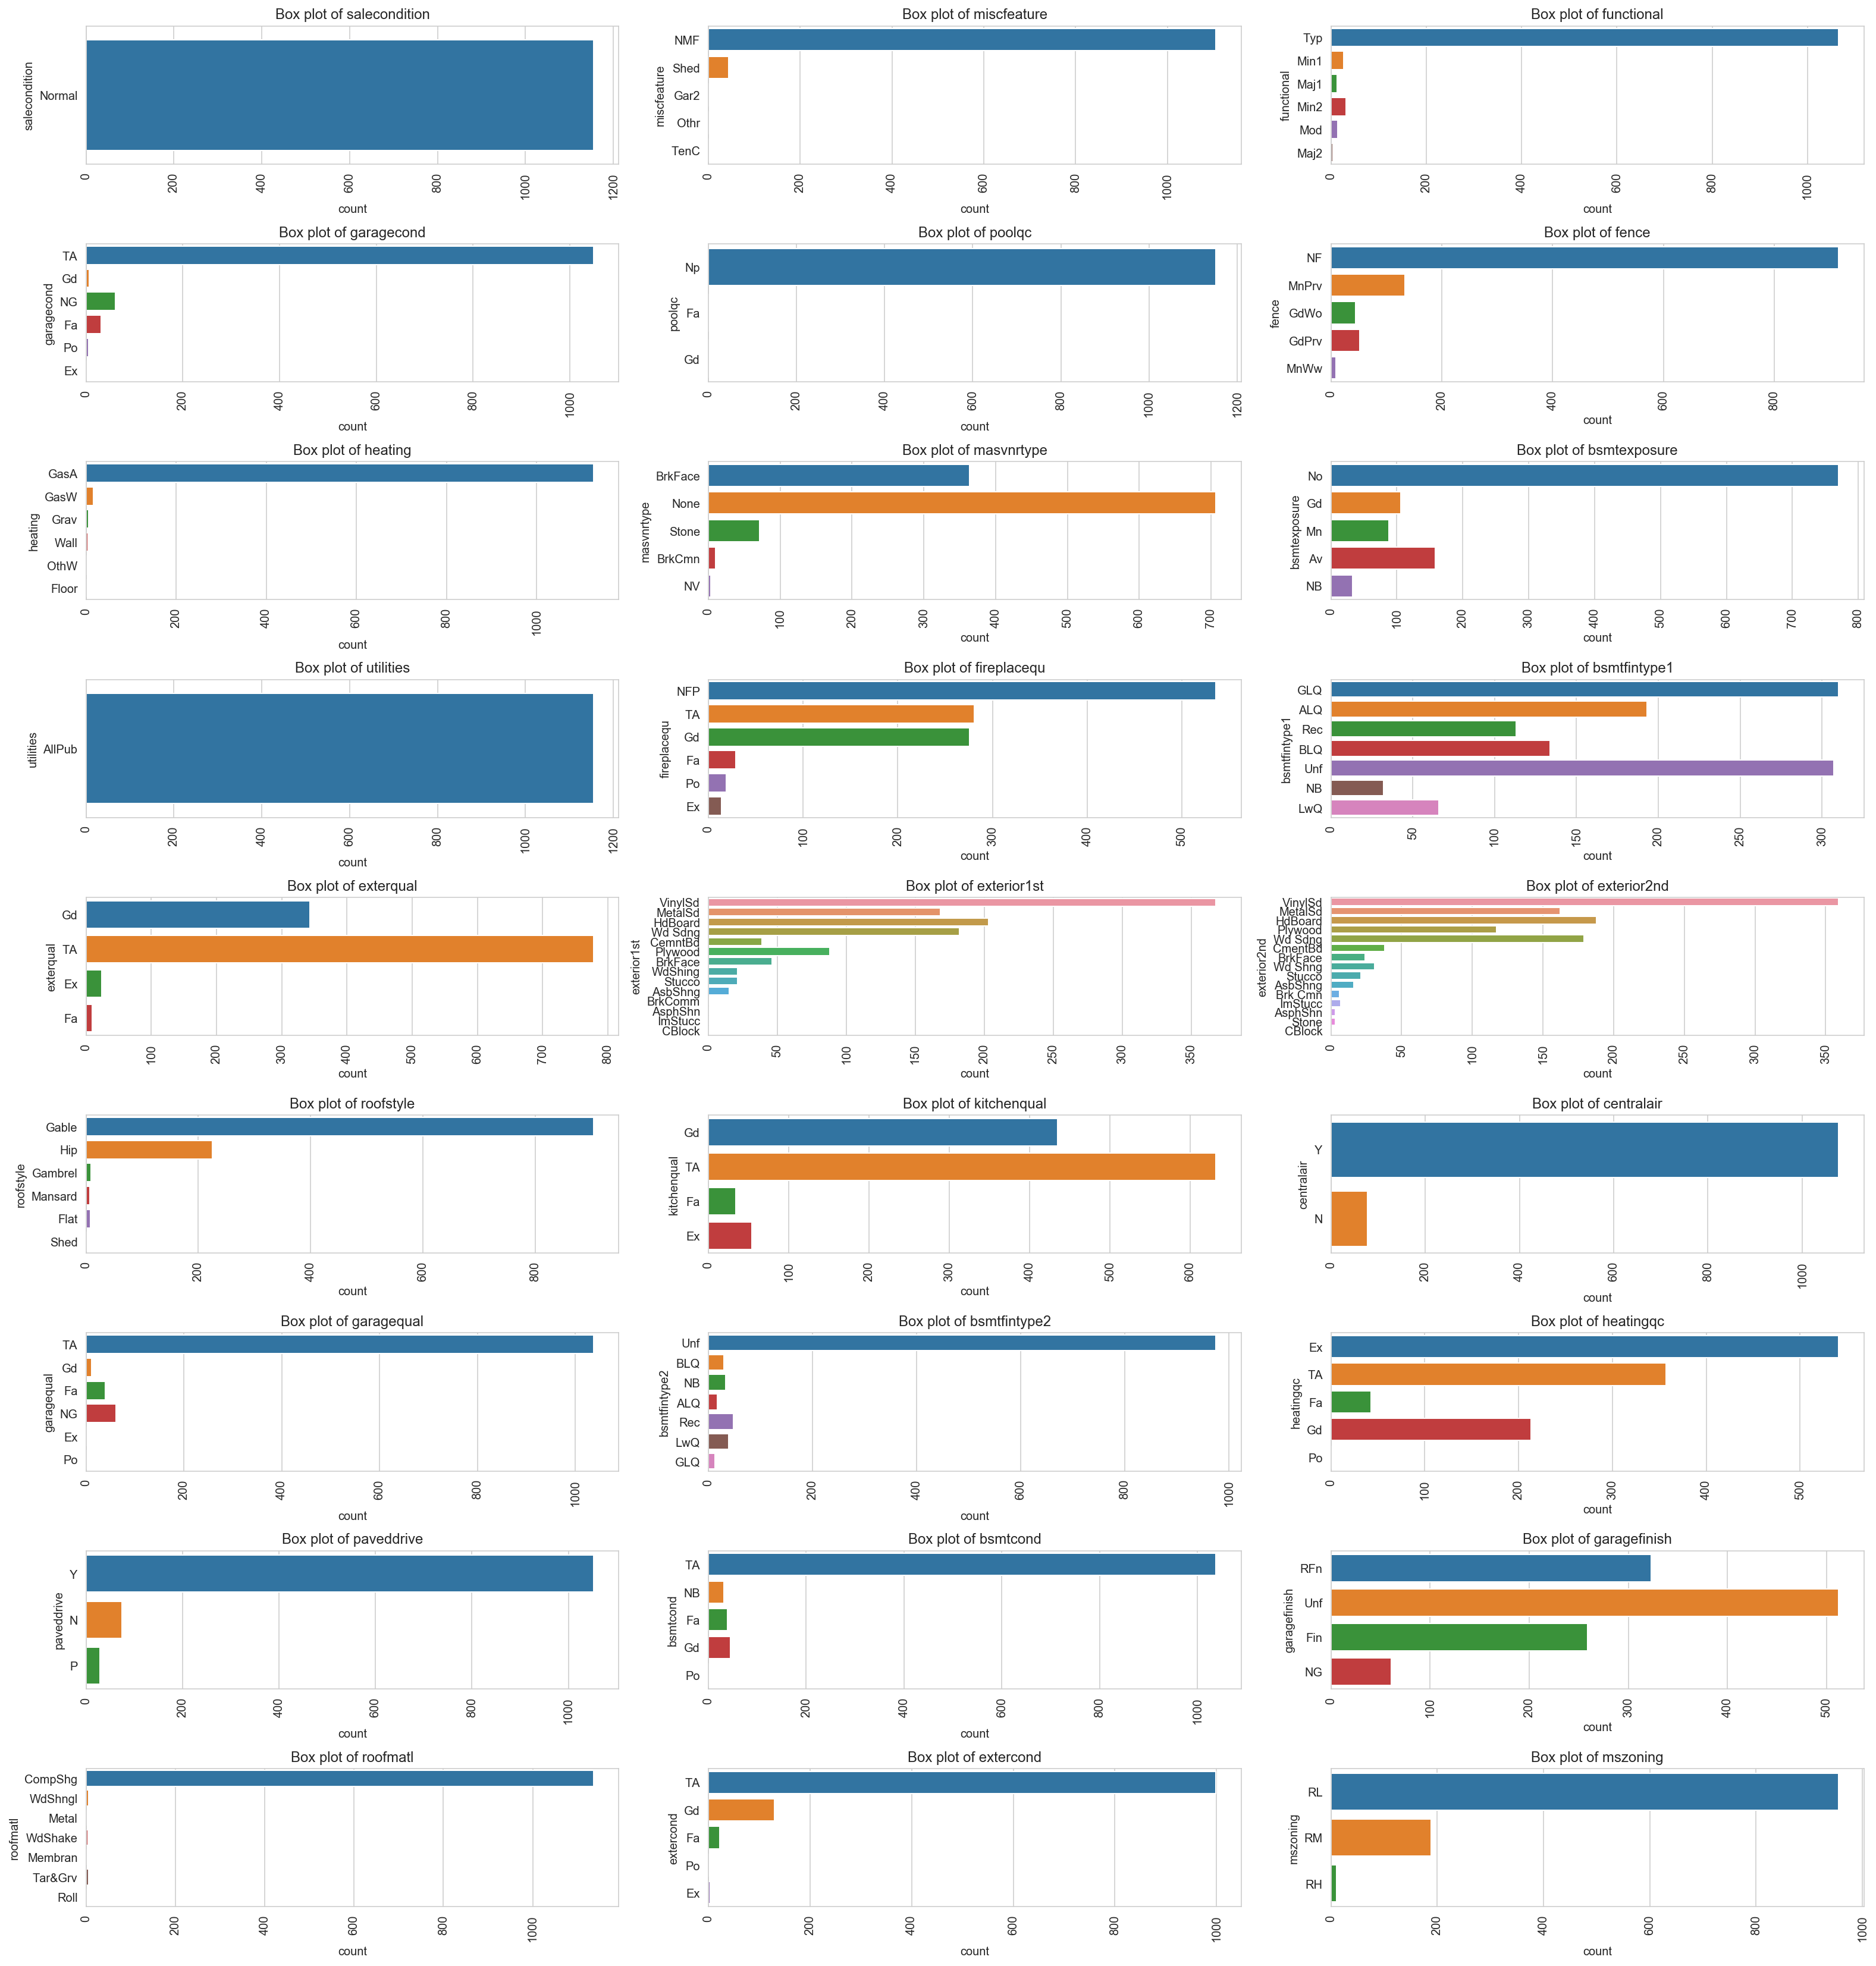

In [90]:
# Box plots for the categorical features:
var = unfixed_cat.columns

fig = plt.figure(figsize=(22,25), facecolor='white')
for i, v in enumerate(var):
    plt.subplot(10,3,i+1)
    sns.countplot(y=v, data=unfixed_cat)
    plt.title('Box plot of {}'.format(v))   
    plt.xticks(rotation='vertical')
plt.tight_layout()

**<u>D. Dummifying<u>**

In [91]:
unfixed_cat_dum = pd.get_dummies(unfixed_cat, drop_first= True)

**<u>E. Merge and Train-test-split<u>**

In [92]:
Ames_final_copy2 = pd.concat([unfixed_num.reset_index(drop=True), unfixed_cat_dum.reset_index(drop=True)], axis=1)

In [93]:
print(Ames_final_copy.shape, Ames_final_copy2.shape)

(1155, 107) (1155, 130)


As before we split the data on pre 2010 and 2010 entries. 

For the purpose of this question our predicted values now become the residuals we calculated in section `2.2.3 F`

In [94]:
residual_train = y_train - ridge_cv.predict(x_train_std)
residual_test = y_test - ridge_cv.predict(x_test_std)

In [95]:
xx_train = Ames_final_copy2[Ames_final_copy2.yrsold <2010]
yy_train = residual_train
xx_test = Ames_final_copy2[Ames_final_copy2.yrsold ==2010]
yy_test= residual_test

**<u>F. Standardising<u>**

In [96]:
scaler2 = StandardScaler()

xx_train_std = pd.DataFrame(scaler2.fit_transform(xx_train), columns = xx_train.columns)
xx_test_std = pd.DataFrame(scaler2.transform(xx_test), columns = xx_test.columns)

In [97]:
print(xx_train.shape,len(yy_train))

(1008, 130) 1008


#### `3.2.2` Using the model

**<u>A. Ridge Regression Model<u>**

In [98]:
unridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 100), cv=5)
unridge_cv.fit(xx_train_std, yy_train)
print(unridge_cv.alpha_)

298.364724028334


In [99]:
unridge_cv.score(xx_test_std, yy_test)

0.15552087141058546

In [100]:
unridge_cvdf = pd.DataFrame({'variables': xx_train_std.columns, 'coef': unridge_cv.coef_})
unridge_cvdfs = unridge_cvdf.sort_values('coef')

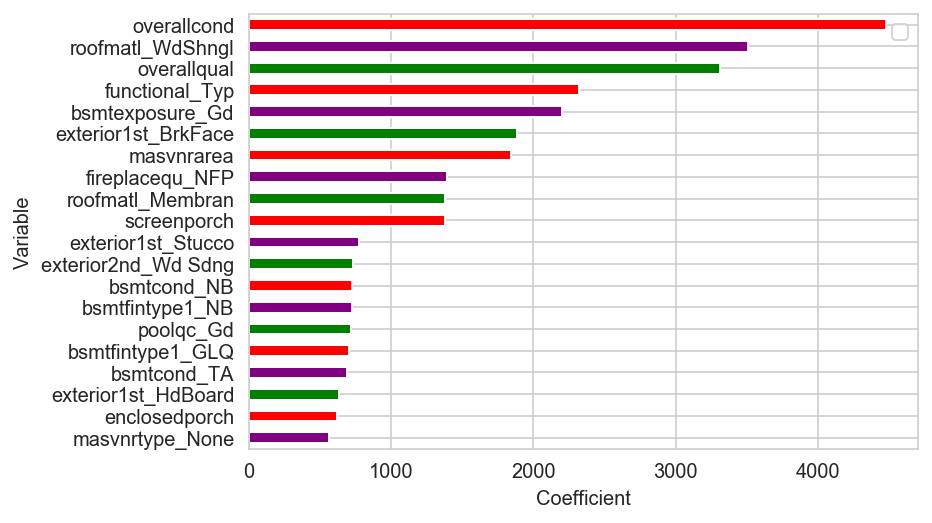

In [101]:
unridge_cvdfs.tail(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['purple', 'red', 'green'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

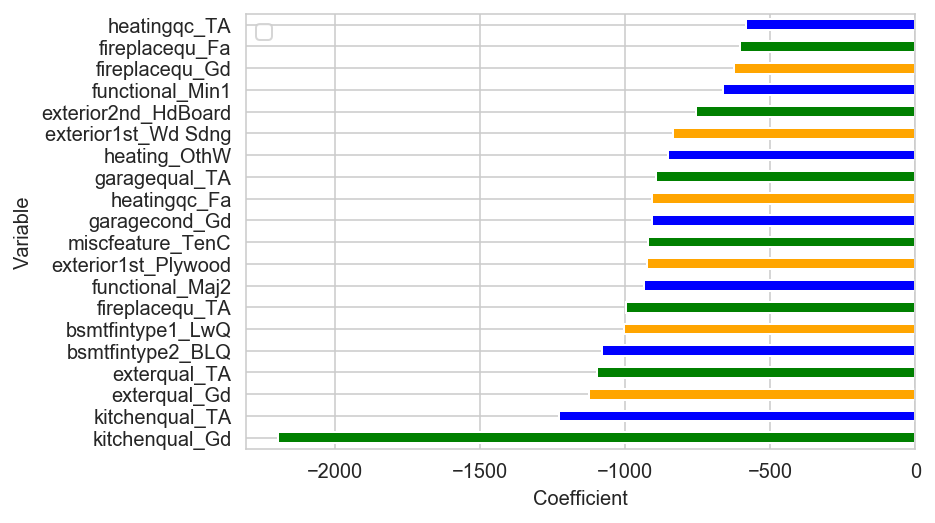

In [102]:
unridge_cvdfs.head(20).plot(kind='barh', x = 'variables', y = 'coef', color = ['green', 'blue', 'orange'])
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend([])
plt.show()

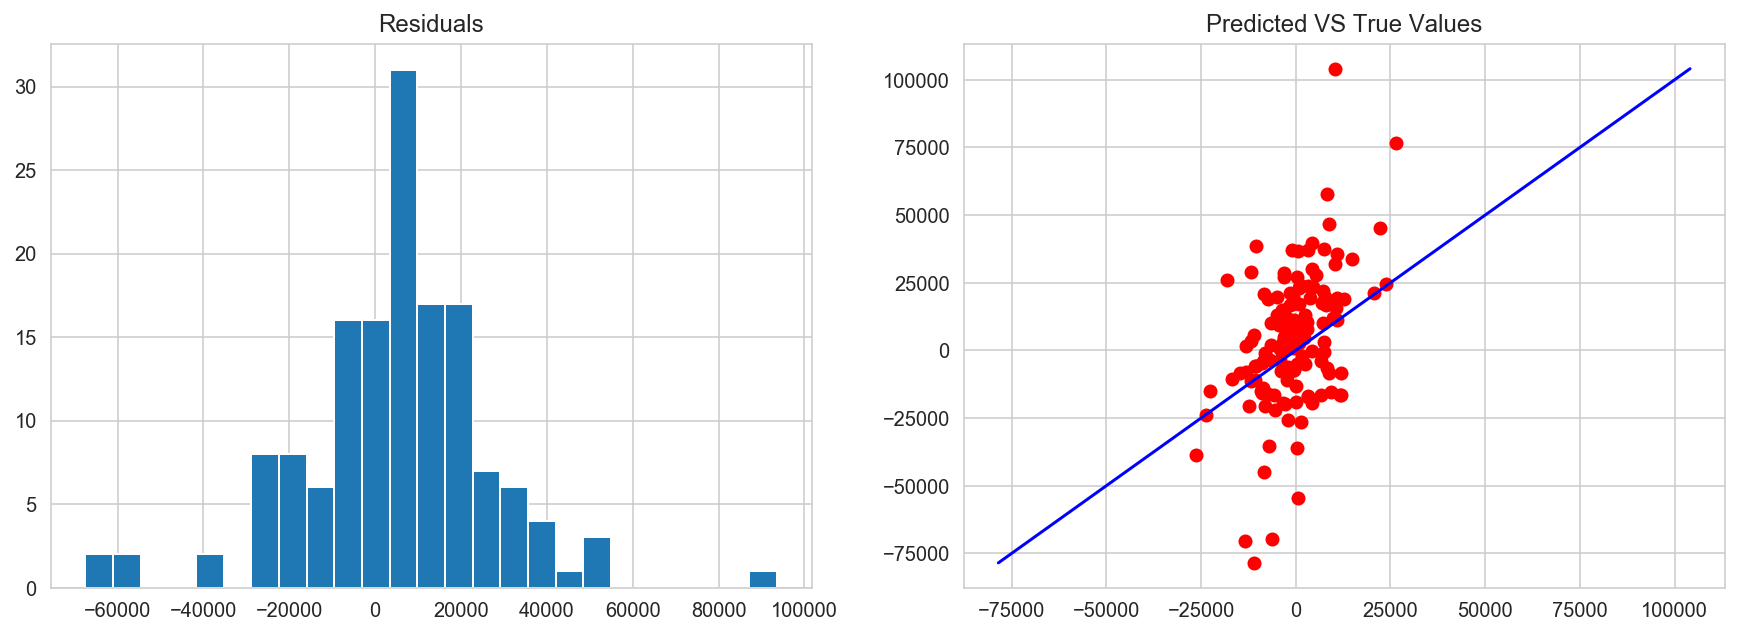

In [103]:
regular__plotter(yy_test, unridge_cv.predict(xx_test_std))

**<u>B. Features to Renovate<u>**

Examining the ridge coefficients for the unfixed characteristics suggests the overall condition is the strongest predictor of price and would be the main target for the company to renovate to increase sale price.

#### `3.2.3` Is the model trustworthy

The score of the second residual model is low therefore it cannot be considered a good model for predicting sale prices.

## `4` Which property characteristics predict an abnormal sale?

### `4.1` Problem

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnormal` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

---

### `4.2` Solution

**<u>A. Modelling**

In [112]:
Ames2_fixed = Ames2[fixed].copy()
Ames2_unfixed = Ames2[unfixed].copy()

missing_count = pd.DataFrame(Ames2_fixed.isna().sum().sort_values(ascending=False), columns=['fixed'])
missing_chars = missing_count[missing_count['fixed'] >= 1]

# Fixed:
# Alley: 
Ames2_fixed.alley.fillna('NA', inplace = True)

# Lotfrontage:
Ames2_fixed.lotfrontage.fillna(0, inplace = True)

# Garageyrblt:
Ames2_fixed.garageyrblt.fillna(0, inplace = True)

# Garagetype:
Ames2_fixed.garagetype.fillna(0, inplace = True)

# Bsmtqual:
Ames2_fixed.bsmtqual.fillna(0, inplace = True)



# Unfixed:
# Poolqc:
Ames2_unfixed.poolqc.fillna('Np', inplace = True)

# Miscfeature:
Ames2_unfixed.miscfeature.fillna('NMF', inplace = True)

# Fence:
Ames2_unfixed.fence.fillna('NF', inplace = True)

# Fireplacequ:
Ames2_unfixed.fireplacequ.fillna('NFP', inplace = True)

# Garagefinish
Ames2_unfixed.garagefinish.fillna('NG', inplace = True)

# Garagecond:
Ames2_unfixed.garagecond.fillna('NG', inplace = True)

# Garagequal:
Ames2_unfixed.garagequal.fillna('NG', inplace = True)

# Bmtexposure:
Ames2_unfixed.bsmtexposure.fillna('NB', inplace = True)

# Bmtfintype2:
Ames2_unfixed.bsmtfintype2.fillna('NB', inplace = True)

# Bmtfintype1:
Ames2_unfixed.bsmtfintype1.fillna('NB', inplace = True)

# Bmtcond:
Ames2_unfixed.bsmtcond.fillna('NB', inplace = True)

# Masvnrtype:
Ames2_unfixed.masvnrtype.fillna('NV', inplace = True)

# Masvnrarea:
Ames2_unfixed.masvnrarea.fillna(0, inplace = True)


Ames3 = pd.concat([Ames2_fixed, Ames2_unfixed], axis=1)

Ames3 = Ames3.loc[:,~Ames3.columns.duplicated()]

It is important to note we have an imbalanced class since the number of sales marked as abnormal makes up only 7% of the dataset.

In [114]:
target = Ames3.salecondition
target_dummy = pd.get_dummies(target)
y = target_dummy.Abnorml.values
target_dummy.head()

Abnorml  AdjLand  Alloca  Family  Normal  Partial
0        0        0       0       0       1        0
1        0        0       0       0       1        0
2        0        0       0       0       1        0
3        1        0       0       0       0        0
4        0        0       0       0       1        0

In addition to Sale Price and Year Sold, we will now use a mix of some of the best performing fixed and unfixed features that were obtained in previous parts of this projetct.

In [115]:
X = Ames3[['saleprice', 'lotarea', 'grlivarea', 'yearbuilt' , 'yearremodadd' , 
           'overallqual' , 'overallcond' ,  'yrsold','masvnrarea']]
X_train, X_test, y_train, y_test = train_test_split(X[['saleprice']], y)
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0010926955721608511

**<u>B. Logitstic Regression**

In [116]:
# Standardize with MinMaxScaler
scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(X)
lr = LogisticRegression()
cross_val_score(lr, X_standardized, y, cv=10).mean()
# This is close to 1 but don't forget we have a high class imbalance

0.9335783547075384

In [118]:
# Train Test Split the data with a 50:50 split.
(X_train, X_test, y_train, y_test) = train_test_split(X_standardized, y, test_size=0.5)

In [119]:
lr_gridsearch = GridSearchCV(LogisticRegression(), 
                             param_grid={'penalty' : ['l1','l2'],
                                        'C' : [50]},
                            cv=25, n_jobs=-1, verbose=1)
lr_gridsearch.fit(X_train, y_train)

Fitting 25 folds for each of 2 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


GridSearchCV(cv=25, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [50], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [120]:
y_pred = lr_gridsearch.predict(X_test)
y_pred_pp = lr_gridsearch.predict_proba(X_test)
y_pred_pp[0:5]
# Here we can see the abnormal category is much smaller

array([[0.95078965, 0.04921035],
       [0.95006431, 0.04993569],
       [0.91235702, 0.08764298],
       [0.91440039, 0.08559961],
       [0.80008495, 0.19991505]])

In [121]:
pp = pd.DataFrame(y_pred_pp, columns=['Normal','Abnormal'])
pp.head()

Normal  Abnormal
0  0.950790  0.049210
1  0.950064  0.049936
2  0.912357  0.087643
3  0.914400  0.085600
4  0.800085  0.199915

In [122]:
# Calculate confusion matrix
conf_mat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
cf = pd.DataFrame(conf_mat, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
cf
# We do not predict any true positives or false negatives due to the imbalance.

predicted_Abnormal  predicted_Normal
Abnormal                   0                40
Normal                     0               653

In [123]:
# We will increase the threshold to 10% to allow more abnormal sales to be predicted
pp['abnormal_thresh_10'] = [1 if x >= 0.1 else 0 for x in pp.Abnormal.values]
pp.head(10)


Normal  Abnormal  abnormal_thresh_10
0  0.950790  0.049210                   0
1  0.950064  0.049936                   0
2  0.912357  0.087643                   0
3  0.914400  0.085600                   0
4  0.800085  0.199915                   1
5  0.964488  0.035512                   0
6  0.946676  0.053324                   0
7  0.925570  0.074430                   0
8  0.823904  0.176096                   1
9  0.906998  0.093002                   0

In [126]:
conmat_thresh_10 = np.array(confusion_matrix(y_test, pp.abnormal_thresh_10.values, labels=[1,0]))
conf_thresh_10 = pd.DataFrame(conmat_thresh_10, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
print('Confusion matrix with 10% prediction threshold')
conf_thresh_10

Confusion matrix with 10% prediction threshold


predicted_Abnormal  predicted_Normal
Abnormal                  16                24
Normal                   119               534

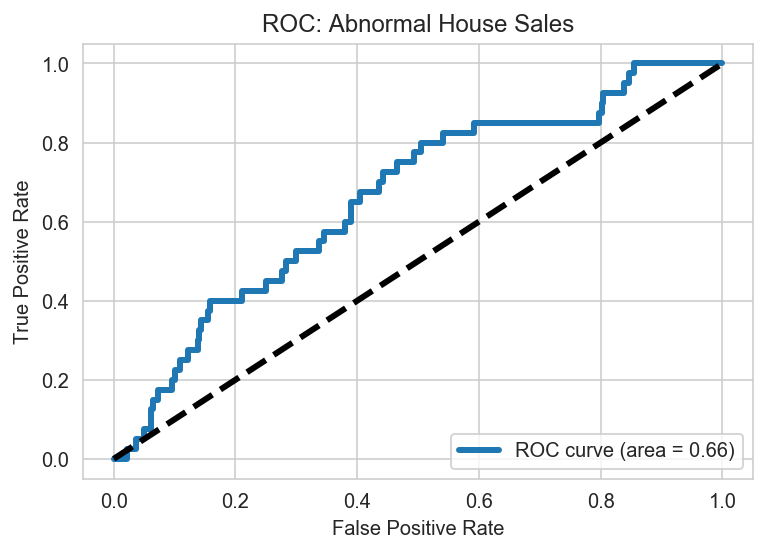

In [127]:
#ROC/AUC plot of the original and threshold
fpr, tpr, _ = roc_curve(y_test, y_pred_pp[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6,4])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Abnormal House Sales')
plt.legend(loc="lower right")
plt.show()